In [1]:
from ground_data import GroundObservations
from LOCSS_data_structure import GaugeCollection
import importlib
import pandas as pd
import os
import datetime as dt
%load_ext autoreload
%autoreload 2

In [28]:
#Generate each lake in a folder
go=GroundObservations()
df_locss_podaac=go.get_locss('LOCSS', all_fds=True)

g_path='../data/locss_2_podaac/by_st'
f_exist=os.path.exists(g_path)
stations=df_locss_podaac['gauge_id'].unique()
df_locss_podaac.rename(columns={'name_x':'name_at_measurement', 'notes_x':'reading_notes', 'name_y':'lake_name',
                                       'notes_y':'installation_notes'}, inplace=True)
st_fields=['gauge_id','lake_name','date','height','is_bubble_level_okay','installation_notes', 'city','latitude','longitude','timezone',
           'unit','min_height','max_height','installation_date','initial_reading','reading_notes', 'updated_at']
df_locss_podaac=df_locss_podaac[st_fields].copy()
if not f_exist:
    os.makedirs(g_path)
for st in stations:
    st_path=g_path+'/'+st
    f_st_exist=os.path.exists(st_path)
    if not f_st_exist:
        os.makedirs(st_path)
    df=df_locss_podaac.loc[df_locss_podaac['gauge_id']==st]
    df.to_csv(st_path+'/LOCSS_'+st+'.csv')

In [25]:
df_locss_podaac.columns


Index(['gauge_id', 'lake_name', 'date', 'height', 'is_bubble_level_okay',
       'installation_notes', 'city', 'latitude', 'longitude', 'timezone',
       'unit', 'min_height', 'max_height', 'installation_date',
       'initial_reading', 'reading_notes', 'updated_at'],
      dtype='object')

In [33]:
#read with no merge for po.daac
dt_fields=['gauge_id','name_x','date','height','is_bubble_level_okay','notes_x']
st_fields=['gauge_id','name','city','latitude','longitude','timezone','unit','min_height','max_height','installation_date','initial_reading','notes', 'updated_at']

dir_ts='../data/readings_up_to_20220404.csv'
dir_loc='../data/gauges_up_to_20220404.csv'
id_fd='gauge_id'
date_fd='date'
time_fd='time'
height_fd='height'
df_locss=pd.read_csv(dir_ts)
df_coord_locss=pd.read_csv(dir_loc, sep=",")
gc=GaugeCollection()

df_locss_filtered=gc.filter_test_gages(df_locss,id_fd).copy()
df_locss_filtered=pd.merge(df_locss_filtered, df_coord_locss, on=id_fd)
df_locss_filtered=df_locss_filtered.loc[(df_locss_filtered[height_fd]>=df_locss_filtered['min_height'])&
                                        (df_locss_filtered[height_fd]<=df_locss_filtered['max_height'])].copy()
df_locss_filtered[date_fd]=pd.to_datetime((df_locss_filtered[date_fd].astype(str)+' '+df_locss_filtered[time_fd].astype(str)), 
                                                  format='%Y-%m-%d %H:%M:%S')


In [34]:
df_locss_filtered=df_locss_filtered[dt_fields]
df_locss_filtered.rename(columns={'name_x':'name', 'notes_x':'notes'}, inplace=True)
df_coord_locss=df_coord_locss[st_fields]
out_path='../data/locss_2_podaac/st_rd/'
f_exist=os.path.exists(out_path)
if not f_exist:
    os.makedirs(out_path)
df_locss_filtered.to_csv(out_path+'locss_readings_up_to_20220404.csv', index=False)
df_coord_locss.to_csv(out_path+'locss_gauges_up_to_20220404.csv', index=False)

In [67]:
#Test getting brasilian ts
import pandas as pd
import os


def _get_all_lakes(file_list, by=None):
    df=pd.DataFrame(file_list, columns=['file_name'])
    df_ex=df['file_name'].str.split('_', expand=True)
    
    df_ex=df_ex.rename(columns={0:'location',1:'lake_id',2:'name'})
    df_ex['name']=df_ex['name'].apply(lambda x:x[:-4])
    df_all=pd.concat((df,df_ex), axis=1)
    if by=='lake_id':
        return df_all['lake_id']
    elif by=='name':
        return df_all['name']
    else:
        return df_all
postfix='.xlsx'
path='../data/brasil/'
files = [f for f in os.listdir(path) if (os.path.isfile(os.path.join(path, f))&
                                                  (f.endswith(postfix)))]
files
start_st=3
end_st=8
st=[f[start_st:end_st] for f in files]
for s in st:
    print(files[st.index(s)])
    
# type(get_all_lakes(data, by='lake_id'))
# type(get_all_lakes(data, by=None))
# type(get_all_lakes(data, by='name'))
# _get_all_lakes(files, by='lake_id')
# df=_get_all_lakes(files, by=None)

# for index, row in df.iterrows():
#     print(row['file_name'])
#     df=pd.read_excel(path+row['file_name'])
#     break
# # [f[] for f in files] 
# df
# f[:-len(postfix)][-length_id:]
# _get_all_lakes(files, by='name')
# df_coord['lon_tx'].astype(float)/100

br_19069_MACHADINHO.xlsx
br_19126_XINGO.xlsx
br_19060_SEGREDO.xlsx


In [ ]:
#To test what is faster 

import xlrd
import timeit

path='/home/angelica/Documents/py_linux/pylocss/data/brasil/br_19126_XINGO.ods'
# xlrd.open_workbook(filename=path)
%timeit pd.read_excel(path, engine='odf')

In [ ]:
path='/home/angelica/Documents/py_linux/pylocss/data/brasil/br_19126_XINGO.xlsx'
# xlrd.open_workbook(filename=path)
%timeit pd.read_excel(path)

In [71]:
from ts_preprocesing import *
%load_ext autoreload
%autoreload 2


In [89]:
#test new function load altis with changes 
g_path='/home/angelica/Dropbox/apps/python_pychm/locss/data/alti_timeseries/'
altis_name='AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017'
altis_name='AlTiS_TimeSeries_Sentinel-3A_0749_S4016'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999
wse_ref='g'
(altiyear, altimonth, altiday, altihour, altiminute, altiwelev)=load_altis(g_path+altis_name+'.csv', 
                                                                               altis_date_fd, altis_height_fd, nodataalti=-9999, wse_ref=wse_ref)

altiwelev

array([639.41776294, 638.79814716, 639.03307506, 639.08598951,
       638.9512785 , 639.22153111, 639.86431209, 639.76201283,
       639.94931077, 639.9821185 , 639.57211619, 639.297528  ,
       639.25073062, 639.17055127, 639.08187817, 639.40142945,
       639.39348567, 639.89583095, 639.7917532 , 640.25812196,
       640.10360696, 640.42202405, 640.42524257, 640.13159718,
       639.72194669, 639.1764573 , 639.00231116, 639.25268834,
       639.51002587, 639.60377963, 639.87170993, 640.49675565,
       640.03452703, 639.76819589, 640.20760798, 640.47443189,
       640.08513394, 639.50381148, 639.14197758, 638.95128786,
       639.06035578, 639.00788169, 639.46582925, 639.97037448,
       639.85536325, 640.67367134, 640.45245077, 640.07032121,
       640.21899268, 640.52368635, 639.96197048, 640.11167615,
       639.65527678, 639.47112128, 639.53081034, 639.4678867 ,
       640.09827893, 640.31512617, 640.54360892, 640.50777014,
       640.37066558, 640.49162851, 640.7388485 , 640.60

In [92]:
#test new function load altis with changes 
g_path='/home/angelica/Dropbox/apps/python_pychm/locss/data/alti_timeseries/'
altis_name='AlTiS_TimeSeries_Sentinel-3A_0749_S4016'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999
wse_ref='e'
ncolgeoid='geoid_01_median'
(altiyear1, altimonth, altiday, altihour, altiminute, altiwelev1)=load_altis(g_path+altis_name+'.csv', 
                                                                            altis_date_fd, altis_height_fd, ncolgeoid=ncolgeoid,
                                                                            nodataalti=-9999, wse_ref=wse_ref)

altiwelev1

array([663.07981069, 662.47482143, 662.70496378, 662.74140667,
       662.61090978, 662.86109502, 663.50252798, 663.39862791,
       663.5459598 , 663.63459361, 663.22171309, 662.94419173,
       662.90517984, 662.82497422, 662.71601449, 663.08318062,
       663.0269616 , 663.57564589, 663.43465858, 663.93466536,
       663.75011991, 664.06734304, 664.06818937, 663.76005322,
       663.35692908, 662.83904057, 662.65802611, 662.89198135,
       663.16243485, 663.24401847, 663.51795276, 664.16366049,
       663.7086631 , 663.43072491, 663.87263624, 664.13096986,
       663.74833067, 663.14252579, 662.7969605 , 662.60973331,
       662.70915986, 662.64661454, 663.1199493 , 663.60987749,
       663.51366899, 664.33485192, 664.10550297, 663.71663475,
       663.86306733, 664.15908874, 663.61175306, 663.31361751,
       662.86337152, 662.66698005, 662.73149651, 662.6737999 ,
       663.30699027, 663.51799969, 663.74929344, 663.69564737,
       663.58061859, 663.69830568, 663.94073831, 663.81

In [100]:
#Making the correction from whole code

text=['AlTiS_TimeSeries_Sentinel-3A_0562_S4128', 'AlTiS_TimeSeries_Sentinel-3B_0026_N4814', 'AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017']
s=[f.find('Sentinel-3') for f in text]
for v in s:
    if v!=-1:
        print('get ellipsoide')
    else:
        print('get geoide')

get ellipsoide
get ellipsoide
get geoide


In [114]:
def get_common_period(df_ts1, df_ts2, date_ts1_fd, date_ts2_fd, delta_days=False, ndays=0):
    '''Get the common period of time between two time series, df_ts1 and df_ts2
        WARNING: If not timezone information in any of the dataframe, utc is assumed 
        It can return the common period + or - a number of days based on df_ts1
        Assume both dataframe datetime is utc
        If delta_days=False, ndays is assume =0, returns a common dataframe with the interception between the two dataframes
        If delta_days=True, ndays has to be different from 0
            Rules:
                if df_ts1 starts earlier than df_ts2, common period starts at initial time of df_ts2
                if df_ts1 starts later than df_ts2, common period starts ndays earlier than initial time of df_ts1
                if df_ts1 ends earlier than df_ts2, common period ends ndays later than final time of df_ts1
                if df_ts1 ends later than df_ts2, common period end at the final time of df_ts2
    '''
    
    if delta_days==True and ndays<=0:
        #TODO:Convert this to raise exceptions
        print('Error ndays cannot be 0 or lower if delta_days=True')
        return None
    if delta_days==False:
        ndays=0
    
    utc=pytz.utc
    
    #Min and max dates in df_ts1 and df_ts2
    if df_ts1[date_ts1_fd].dt.tz is None:
        df_ts1[date_ts1_fd]=[utc.localize(date) for date in df_ts1[date_ts1_fd]]
        
    if df_ts2[date_ts2_fd].dt.tz is None:
        df_ts2[date_ts2_fd]=[utc.localize(date) for date in df_ts2[date_ts2_fd]]
        
    earlier_date_ts1=min(df_ts1[date_ts1_fd])
    final_date_ts1=max(df_ts1[date_ts1_fd])
        
    earlier_date_ts2=min(df_ts2[date_ts2_fd])
    final_date_ts2=max(df_ts2[date_ts2_fd])

    if earlier_date_ts1 >= earlier_date_ts2:
        initial_date=earlier_date_ts1 - dt.timedelta(days=ndays)
    else:
        initial_date=earlier_date_ts2

    if final_date_ts1 >= final_date_ts2:
        end_date=final_date_ts2
    else:
        end_date=final_date_ts1 + dt.timedelta(days=ndays)
    
    #filter dataframes
    df_ts1=df_ts1.loc[(df_ts1[date_ts1_fd]>=initial_date)&(df_ts1[date_ts1_fd]<=end_date)].copy()
    df_ts2=df_ts2.loc[(df_ts2[date_ts2_fd]>=initial_date)&(df_ts2[date_ts2_fd]<=end_date)].copy()
    
    return (df_ts1, df_ts2)


In [135]:
import pandas as pd
import pytz
from datetime import datetime, timezone
import datetime as dt

s_dict={'date': ['2001-12-20','2002-01-05','2002-01-15','2002-02-04','2002-02-09'], 'val':[1.5,2,2.4,3,2]}
g_dict={'date': ['2002-01-01','2002-01-02','2002-01-03',
                 '2002-01-04','2002-01-05','2002-01-06',
                '2002-01-08','2002-01-10','2002-01-14',
                '2002-01-15','2002-01-18','2002-01-20',
                '2002-01-21','2002-02-07','2002-02-08'], 'val':[1.5,2,1,
                                                                2,2.4,3,
                                                               2,2.1,2.2,
                                                               2,1,1,
                                                               2,2.5,1]}
df_s=pd.DataFrame(s_dict)
df_s['date']=pd.to_datetime(df_s['date'], utc=True)

df_g=pd.DataFrame(g_dict)
df_g['date']=pd.to_datetime(df_g['date'])#, utc=True)
df_g['date'].dt.tz

In [136]:
df_s

,date,val
0,2001-12-20 00:00:00+00:00,1.5
1,2002-01-05 00:00:00+00:00,2.0
2,2002-01-15 00:00:00+00:00,2.4
3,2002-02-04 00:00:00+00:00,3.0
4,2002-02-09 00:00:00+00:00,2.0


In [137]:
df_g

,date,val
0,2002-01-01,1.5
1,2002-01-02,2.0
2,2002-01-03,1.0
3,2002-01-04,2.0
4,2002-01-05,2.4
5,2002-01-06,3.0
6,2002-01-08,2.0
7,2002-01-10,2.1
8,2002-01-14,2.2
9,2002-01-15,2.0


In [138]:
df_sx, df_gx=get_common_period(df_ts1=df_s, df_ts2=df_g, date_ts1_fd='date', date_ts2_fd='date', delta_days=True, ndays=2)

In [139]:
df_sx

,date,val
1,2002-01-05 00:00:00+00:00,2.0
2,2002-01-15 00:00:00+00:00,2.4
3,2002-02-04 00:00:00+00:00,3.0


In [140]:
df_gx

,date,val
0,2002-01-01 00:00:00+00:00,1.5
1,2002-01-02 00:00:00+00:00,2.0
2,2002-01-03 00:00:00+00:00,1.0
3,2002-01-04 00:00:00+00:00,2.0
4,2002-01-05 00:00:00+00:00,2.4
5,2002-01-06 00:00:00+00:00,3.0
6,2002-01-08 00:00:00+00:00,2.0
7,2002-01-10 00:00:00+00:00,2.1
8,2002-01-14 00:00:00+00:00,2.2
9,2002-01-15 00:00:00+00:00,2.0


In [141]:


def filter_date(df, date, delta, v_fd, d_fd):
    df_t=df.loc[(df[d_fd]>=(date-dt.timedelta(days=delta)))&(df[d_fd]<=(date+dt.timedelta(days=delta)))]
    return df_t[v_fd].median(skipna=True),df_t[v_fd].mean(skipna=True), df_t[v_fd].count()

# df_s[['mv','md']]=
# print(
delta=2
median_fd='median_d_'+str(delta)
mean_fd='mean_d_'+str(delta)
count_fd='count_d_'+str(delta)

df_s[[median_fd,mean_fd, count_fd]]=df_sx.apply(lambda x: filter_date(df_gx,x['date'],delta,'val','date'), axis=1).apply(pd.Series)

# for index, row in df_s.iterrows():
#     print(row['date']-dt.timedelta(days=2))
#     print(row['date']+dt.timedelta(days=2))
#     df_t=df_g.loc[(df_g['date']>=(row['date']-dt.timedelta(days=2)))&(df_g['date']<=(row['date']+dt.timedelta(days=2)))]
#     print(df_t, '\n')
#     mean_x=df_t['val'].median()
#     print(mean_x, df_t)
df_s

,date,val,median_d_2,mean_d_2,count_d_2
0,2001-12-20 00:00:00+00:00,1.5,NaN,NaN,NaN
1,2002-01-05 00:00:00+00:00,2.0,2.2,2.1,4.0
2,2002-01-15 00:00:00+00:00,2.4,2.1,2.1,2.0
3,2002-02-04 00:00:00+00:00,3.0,NaN,NaN,0.0
4,2002-02-09 00:00:00+00:00,2.0,NaN,NaN,NaN


In [88]:
#Read all the data from Bangladehs original data files
import pandas as pd
import numpy as np

#Read locss gauges for codes 
#Read Excel file 
path_to_read='C:/Users/amgomez/Dropbox/Research/LOCSS/Docs/Bangladesh_Data September_December.xlsx'
xl=pd.ExcelFile(path_to_read)

list_names=xl.sheet_names
print(len(list_names))
lk_name_fd='lake_name'
df_final=pd.DataFrame() #final dataframe with all data include duplicates
df_final_ndp=pd.DataFrame() #final dataframe removing duplicates. Leaving the last value 
df_duplicates=pd.DataFrame()#final dataframe with all the dates that repeat
for lk_name in list_names:
    
    df=pd.read_excel(path_to_read, sheet_name=lk_name)
    #print (df.shape)
    date_fd=df.columns[0] #Assuming date is always in the first column
    height_fd=df.columns[1]
    df['source']='LOCSS'
    df[lk_name_fd]=lk_name
    #df[id_fd]=station_id #Pending to get the station
    df=df.rename(columns={height_fd:'height',date_fd:'Date'}) #Unify the name of the stations
    date_fd='Date'
    height_fd='height'
    try: 
        df[date_fd]=pd.to_datetime(df[date_fd])
    except Exception as e:
        print ('Error in '+lk_name,e)
    else:
        df=df.sort_values(by=date_fd)
        df['diff_val']=df[height_fd].diff()
        df['diff_date']=df[date_fd].diff().apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')
        date_duplicate_mask=df[date_fd].duplicated(keep=False)
        #print('Duplicated\n',date_duplicate_mask)
        df_dp=df[date_duplicate_mask].copy()
        df_ndp=df.drop_duplicates(subset=[date_fd, lk_name_fd], keep='last').copy()
        #concat to final dataframes
        df_final=pd.concat((df_final, df), axis=0)
        df_duplicates=pd.concat((df_duplicates, df_dp), axis=0)
        df_final_ndp=pd.concat((df_final_ndp, df_ndp), axis=0)
    # break
print('\n All data with duplicates', '\n'+str(df_final.shape))
print('\n Only Duplicates\n',str(df_duplicates.shape))
print('\nAll data NO Duplicates\n',str(df_final_ndp.shape))

len(df_final[lk_name_fd].unique())
 

50
Error in Talar Haor Sunamganj Unknown string format: no data 

 All data with duplicates 
(10584, 7)

 Only Duplicates
 (704, 7)

All data NO Duplicates
 (10215, 7)


49

In [89]:
#Identify if the duplicates are the same or not
df_dp=df_duplicates.copy()
df_dp['is_0']=['Yes' if x==0 else 'No' for x in df_dp['diff_val']]
df_dp

,Date,height,source,lake_name,diff_val,diff_date,Unnamed: 2,is_0
0,2021-09-01 09:00:00,7.25,LOCSS,Medol Haor Sylhet,NaN,0,NaN,No
1,2021-09-01 09:00:00,7.25,LOCSS,Medol Haor Sylhet,0.00,0,NaN,Yes
2,2021-09-01 15:00:00,7.26,LOCSS,Medol Haor Sylhet,0.01,360,NaN,No
3,2021-09-01 15:00:00,7.21,LOCSS,Medol Haor Sylhet,-0.05,0,NaN,No
10,2021-09-04 09:00:00,10.77,LOCSS,Medol Haor Sylhet,-0.23,1080,NaN,No
...,...,...,...,...,...,...,...,...
73,2021-10-06 15:00:00,6.47,LOCSS,Putiyar Haor Netrokona,-0.01,0,NaN,No
68,2021-10-06 09:00:00,6.79,LOCSS,Buai Haor Netrokona,-0.01,1080,NaN,No
69,2021-10-06 09:00:00,6.79,LOCSS,Buai Haor Netrokona,0.00,0,NaN,Yes
70,2021-10-06 15:00:00,6.79,LOCSS,Buai Haor Netrokona,0.00,360,NaN,Yes


In [95]:
#Get amount of non-equal duplicates per date 
df_count_dp=df_duplicates.loc[df_duplicates['diff_val']!=0].groupby([date_fd, lk_name_fd],as_index=False).size()
df_count_dp
#Get amount of non-equal duplicates by lake and size
df_count_dp_by_lake=df_count_dp.rename(columns={'size':'class'}).groupby([lk_name_fd, 'class'], as_index=False).size()
df_count_dp_by_lake=df_count_dp_by_lake.sort_values(by=lk_name_fd)

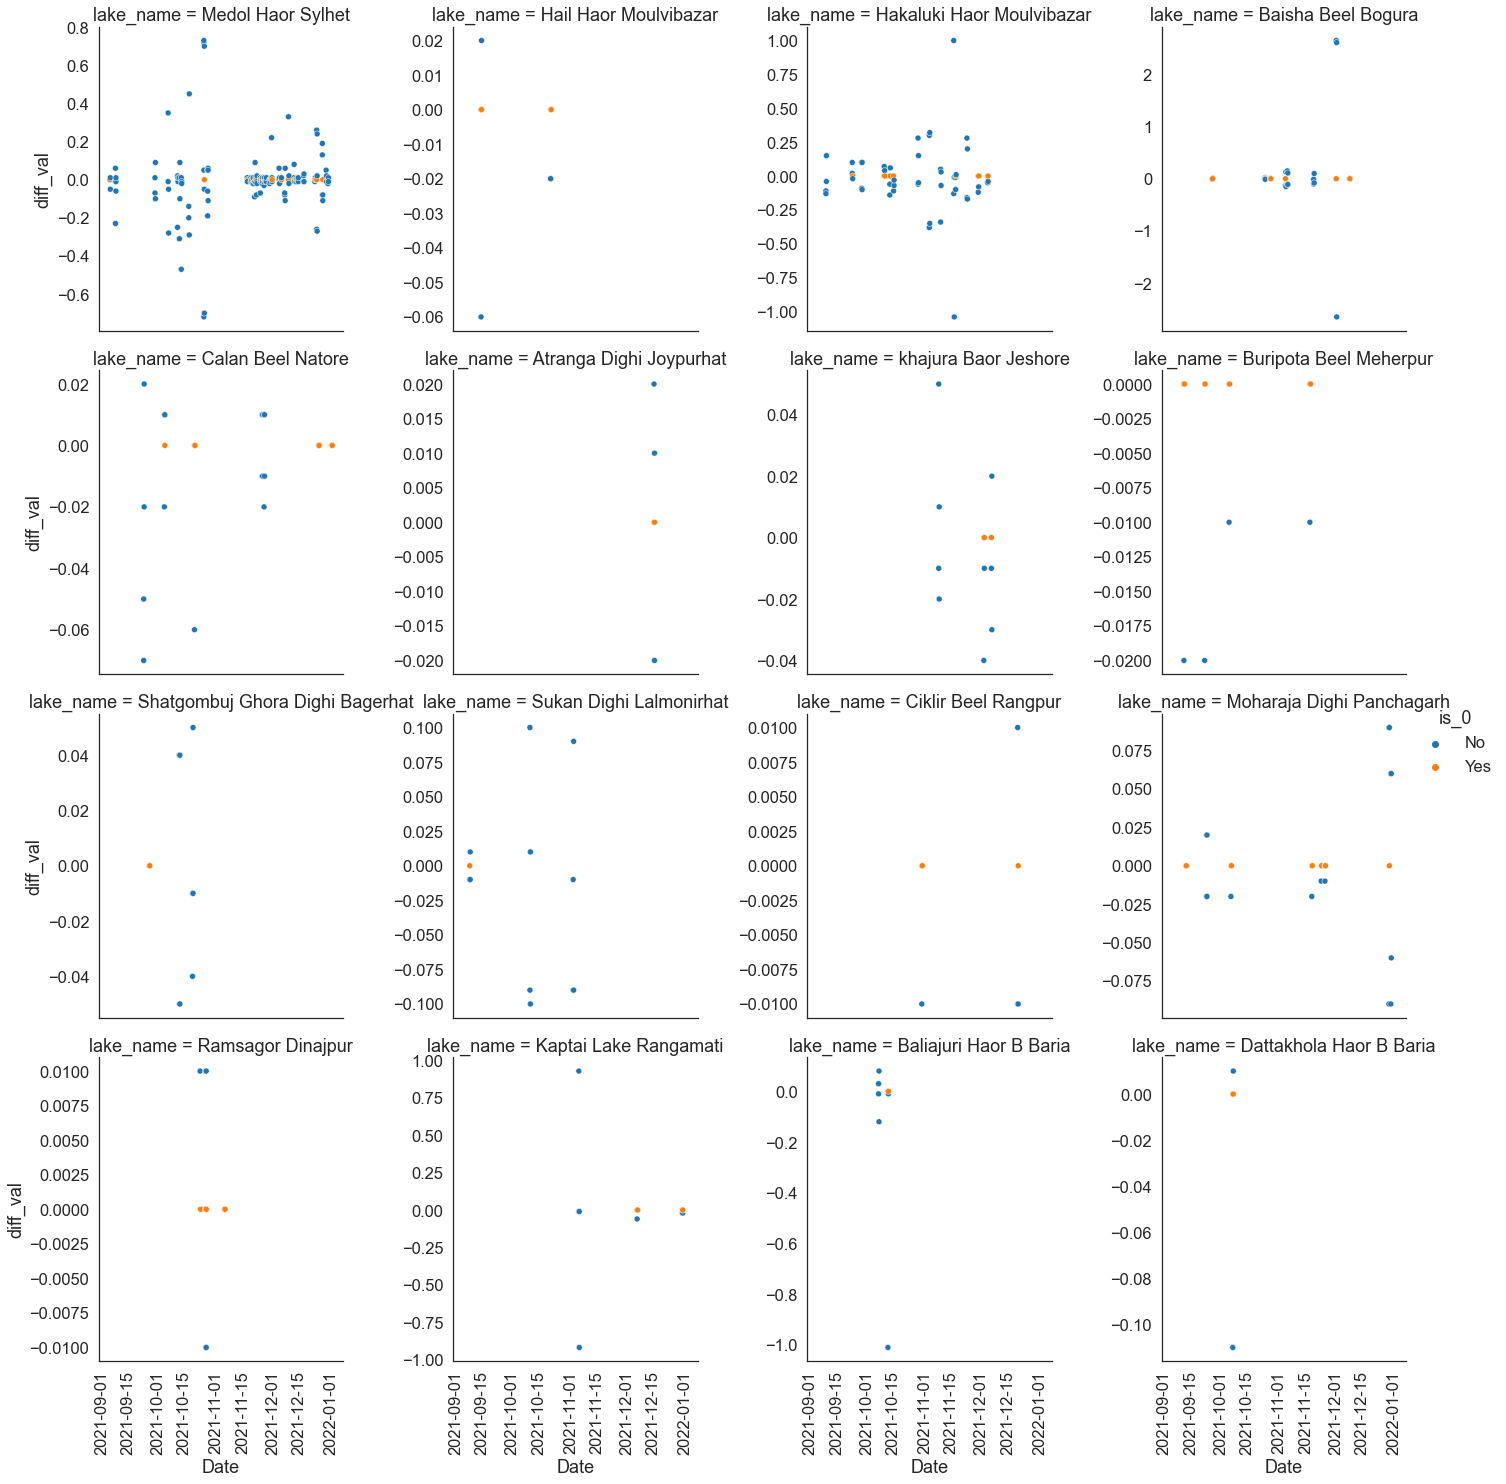

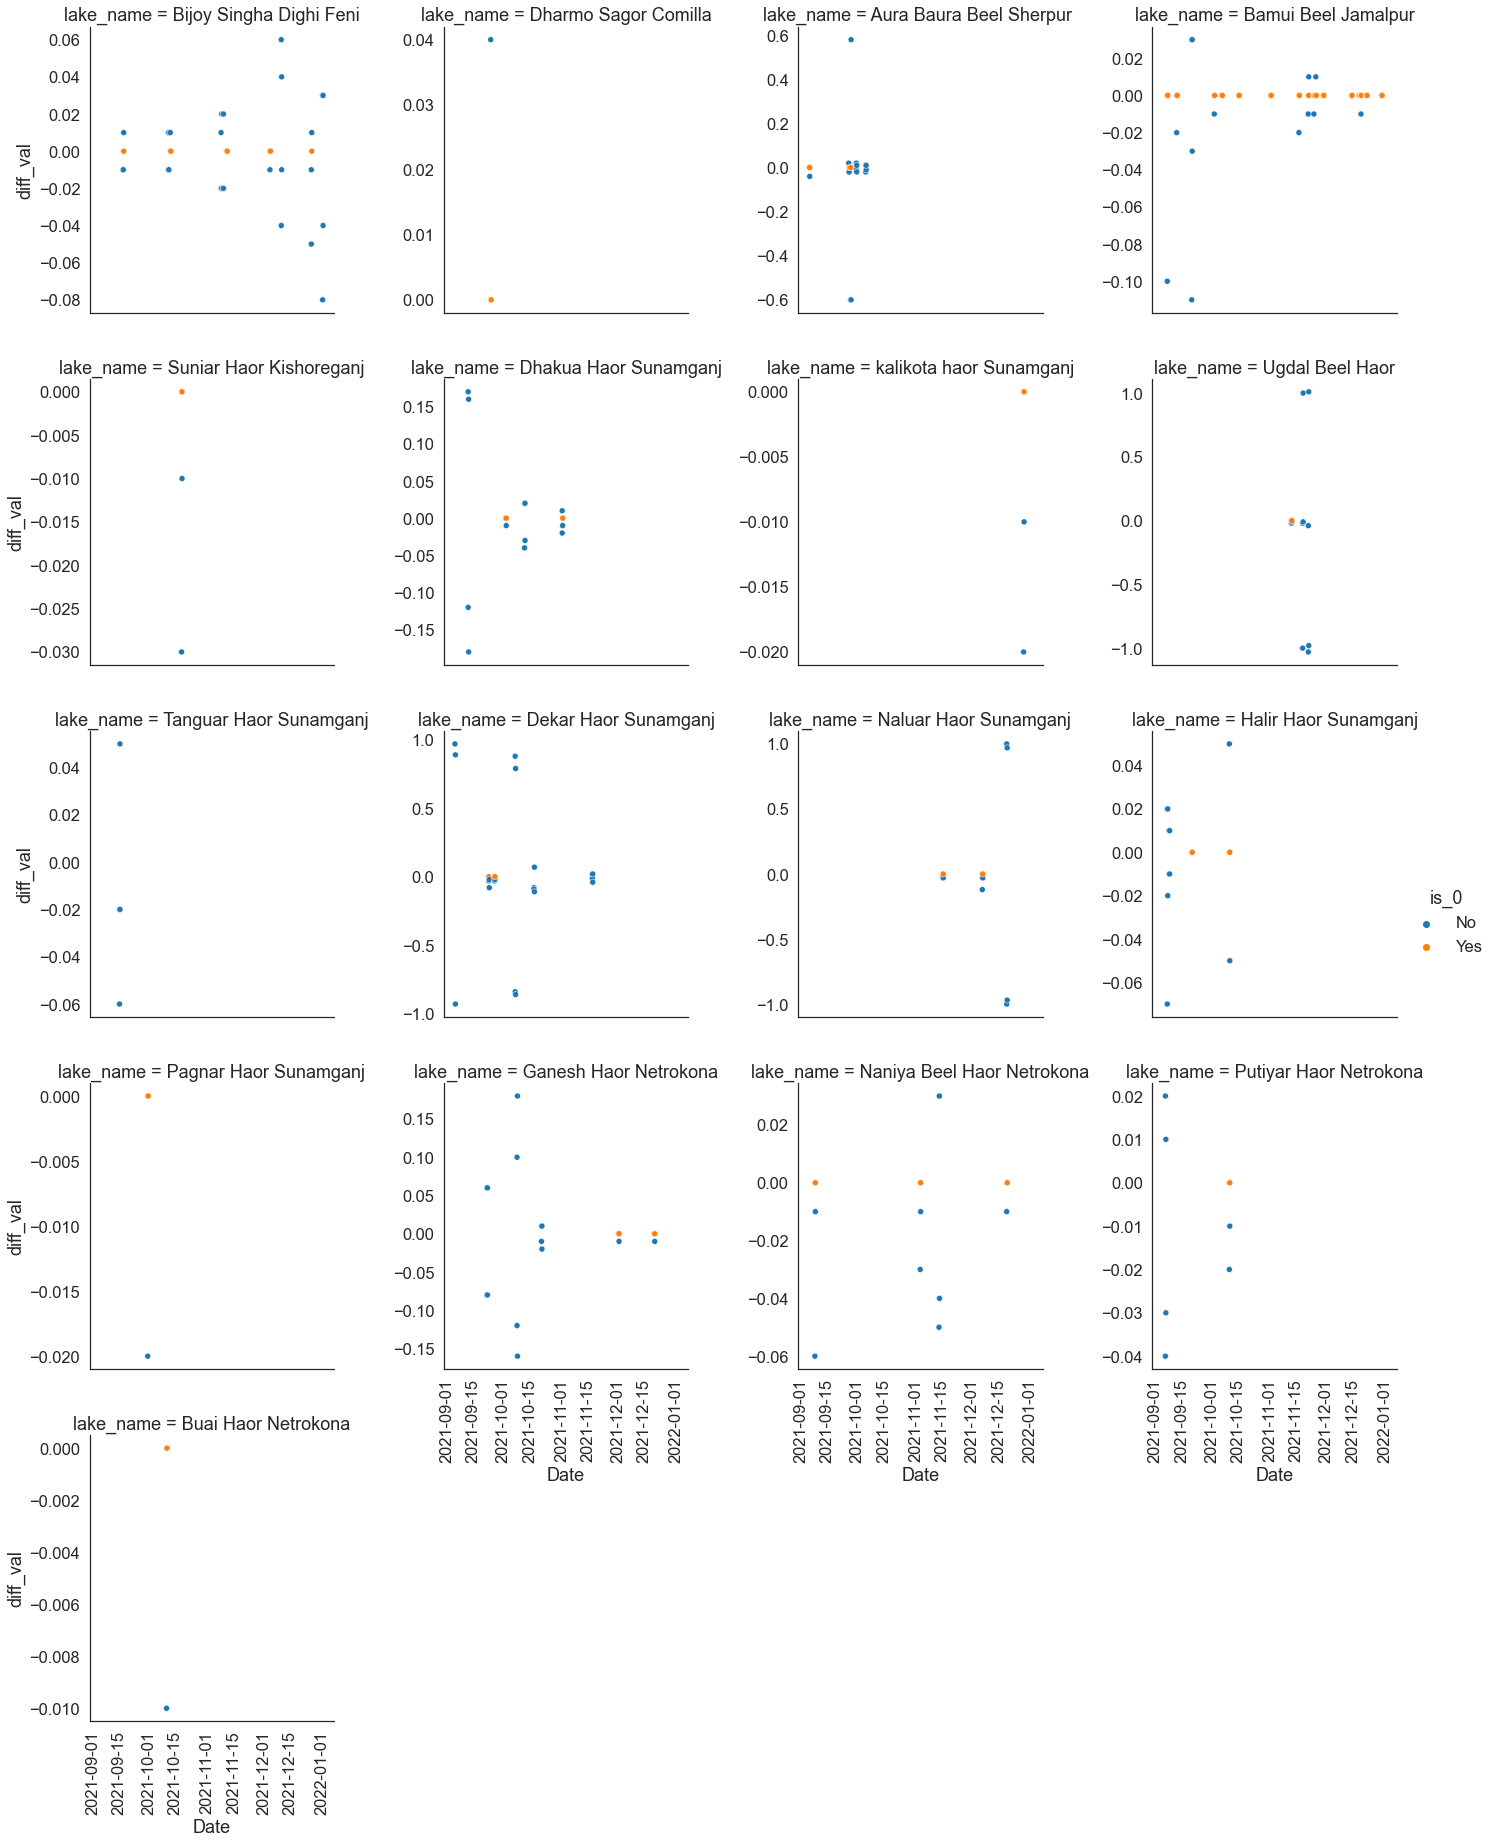

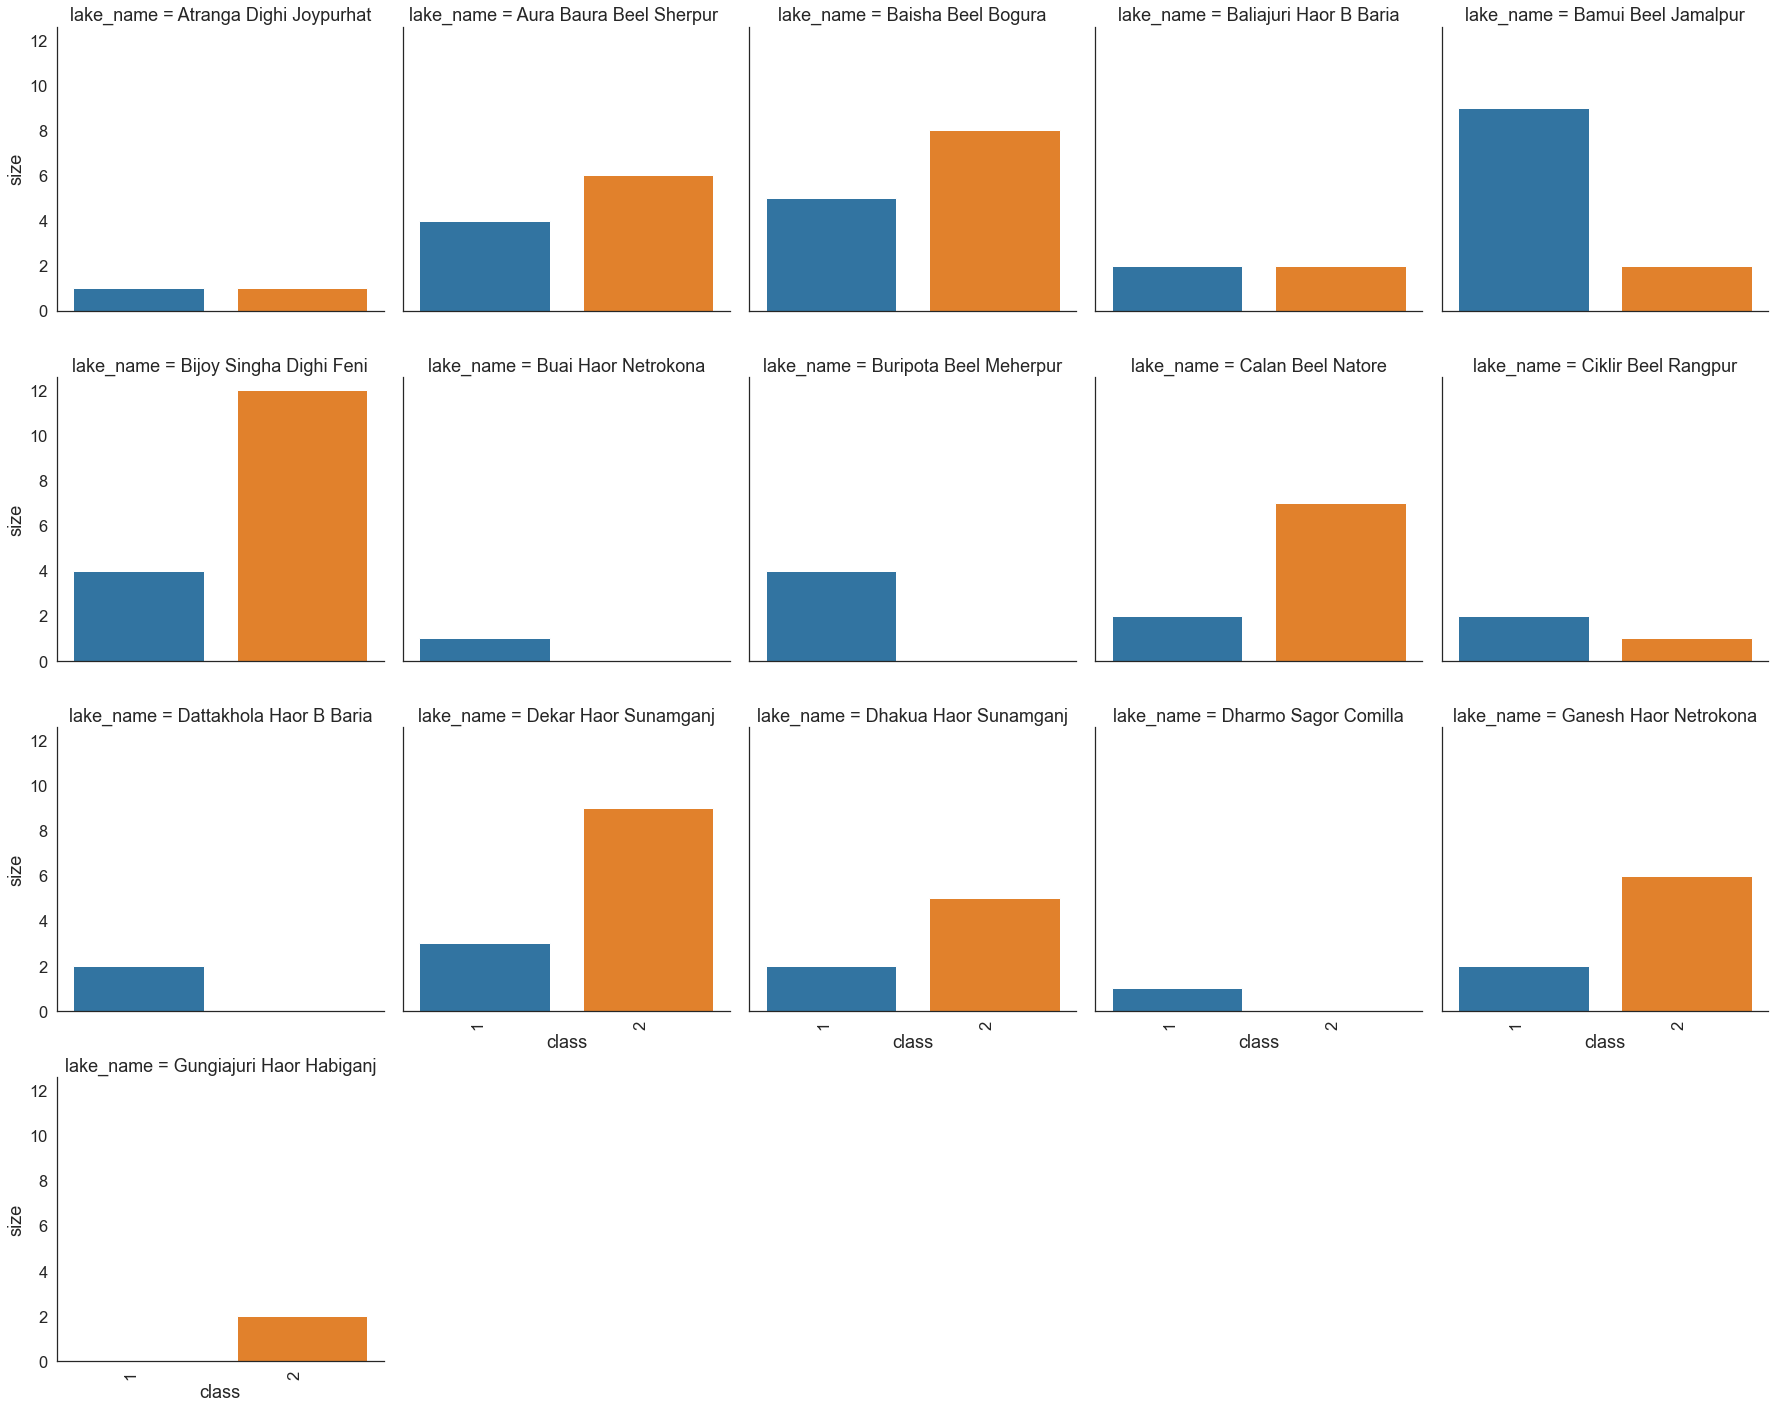

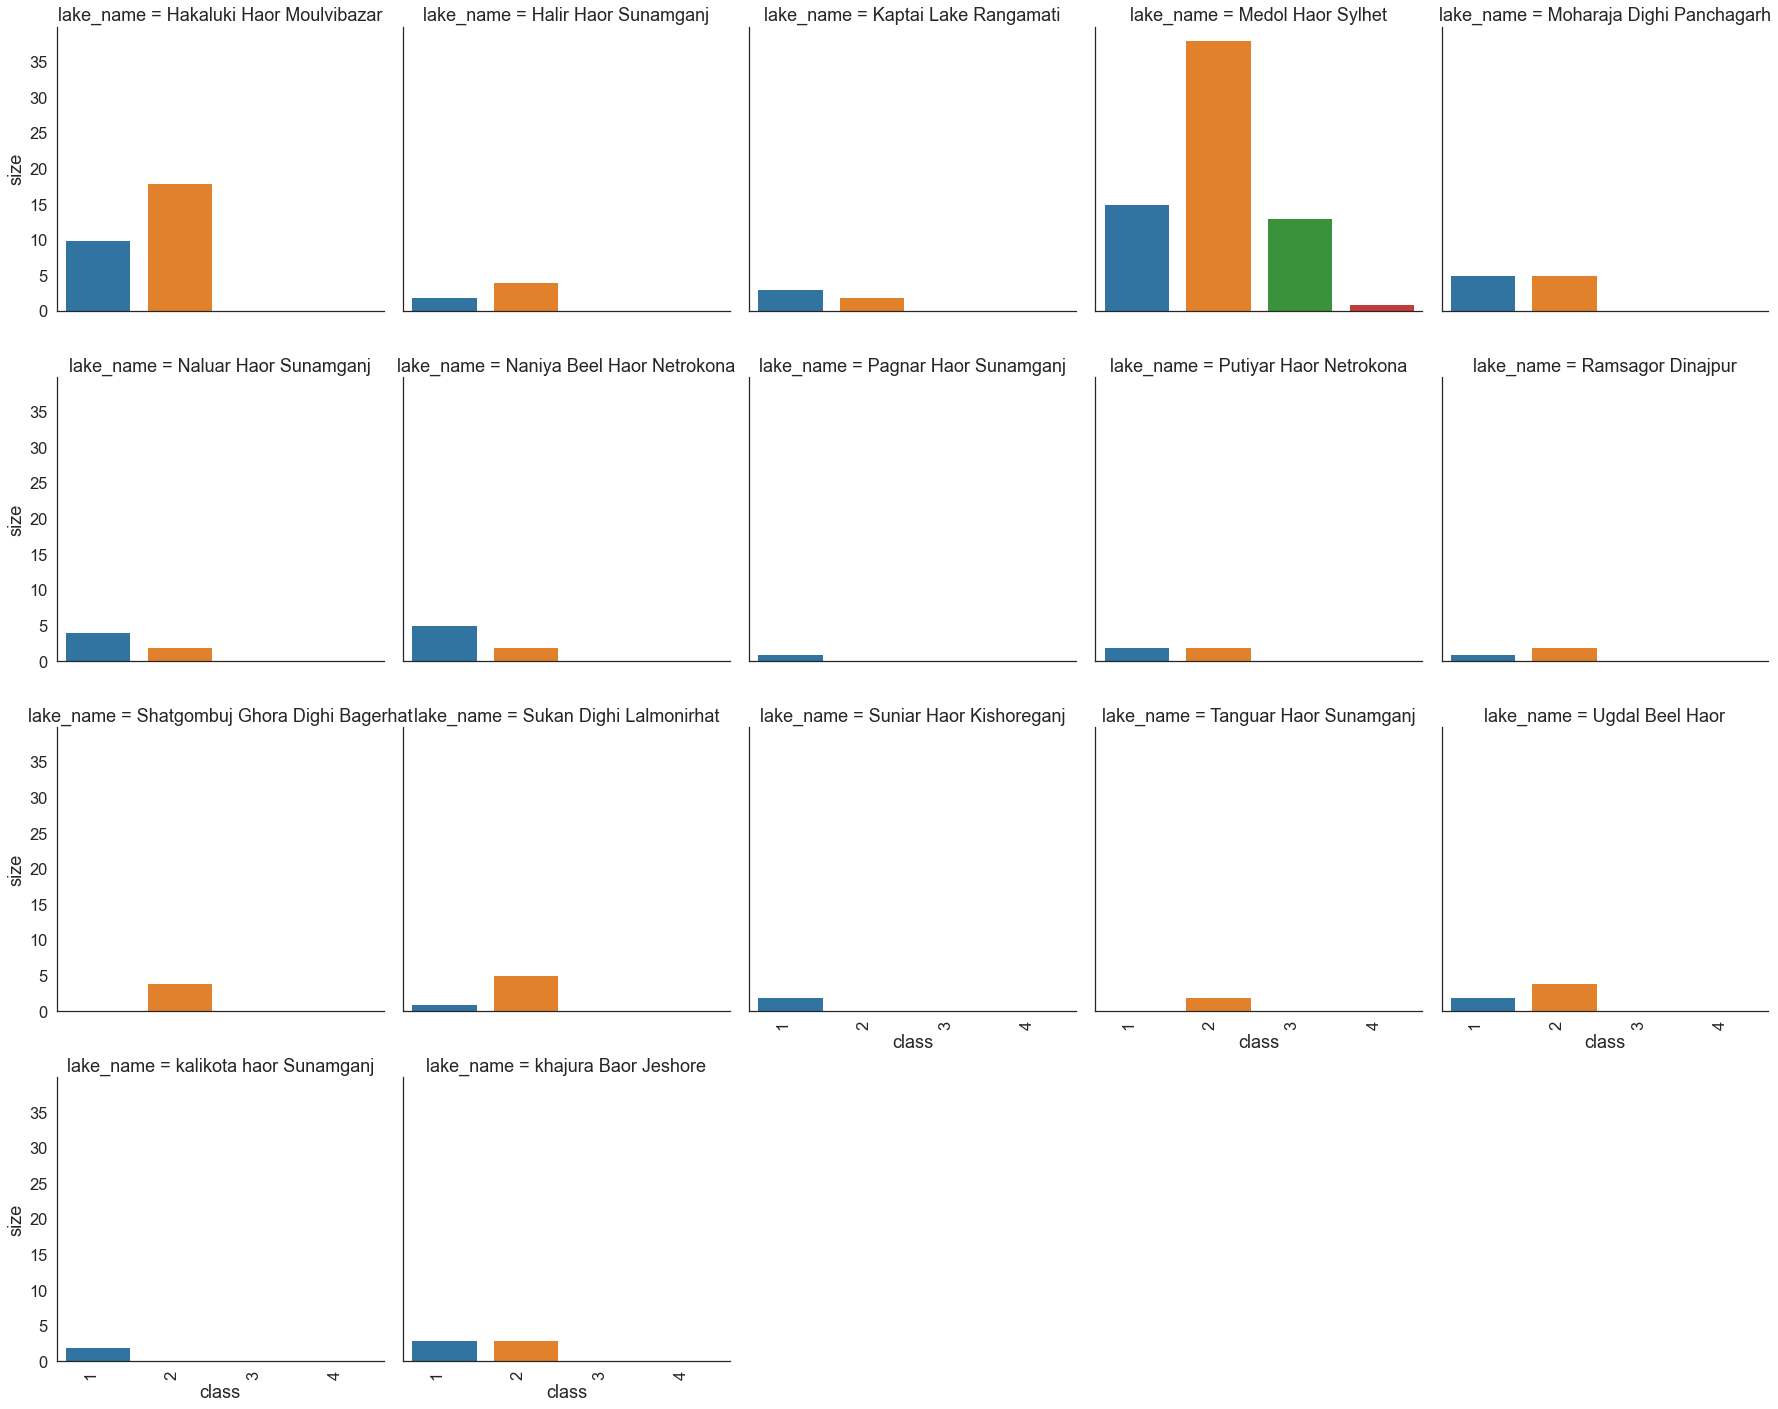

In [115]:
import seaborn as sns
from datetime import date

sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)

df=df_dp
x_field=date_fd
y_field='diff_val'
hue='is_0'
col=lk_name_fd
col_wrap=4
facet_kws={'sharey': False, 'sharex': True}
#Split the figure in two
idx_first=int(len(df[lk_name_fd].unique())/2-1)
idx_last=int(len(df[lk_name_fd].unique())/2)
first_set=df[lk_name_fd].unique()[:idx_first]
last_set=df[lk_name_fd].unique()[idx_last:]

g_sn=sns.relplot(data=df.loc[df[lk_name_fd].isin(first_set)], 
                 x=x_field, y=y_field, hue=hue, 
                 col=col,col_wrap=col_wrap, facet_kws=facet_kws)
g_sn.set_xticklabels(rotation=90, horizontalalignment='right')
g_sn.savefig('../data/dup_bg_by_date_lake_1_'+date.today().strftime("%Y%m%d")+'.png')

g_sn=sns.relplot(data=df.loc[df[lk_name_fd].isin(last_set)], 
                 x=x_field, y=y_field, hue=hue, 
                 col=col,col_wrap=col_wrap, facet_kws=facet_kws)
g_sn.set_xticklabels(rotation=90, horizontalalignment='right')
g_sn.savefig('../data/dup_bg_by_date_lake_2_'+date.today().strftime("%Y%m%d")+'.png')

# g_num=sns.relplot(data=df_count_dp, x=x_field, y='size', col=col,col_wrap=col_wrap)
# g_num.set_xticklabels(rotation=90, horizontalalignment='right')

first_set=df_count_dp_by_lake[lk_name_fd].unique()[:idx_first]
last_set=df_count_dp_by_lake[lk_name_fd].unique()[idx_last:]
df=df_count_dp_by_lake.loc[df_count_dp_by_lake[lk_name_fd].isin(first_set)]

g_num=sns.catplot(data=df, x='class', y='size', col=col,col_wrap=5, kind='bar')
g_num.set_xticklabels(rotation=90, horizontalalignment='right')
g_num.savefig('../data/dup_bg_count_by_lake_class_1_'+date.today().strftime("%Y%m%d")+'.png')

df=df_count_dp_by_lake.loc[df_count_dp_by_lake[lk_name_fd].isin(last_set)]

g_num=sns.catplot(data=df, x='class', y='size', col=col,col_wrap=5, kind='bar')
g_num.set_xticklabels(rotation=90, horizontalalignment='right')
g_num.savefig('../data/dup_bg_count_by_lake_class_2_'+date.today().strftime("%Y%m%d")+'.png')

In [116]:
#Diff between last duplicated values
df_dp_diff=df_final.drop_duplicates(subset=[date_fd, lk_name_fd], keep='last').copy()#.loc[df_duplicates['diff_val']!=0]



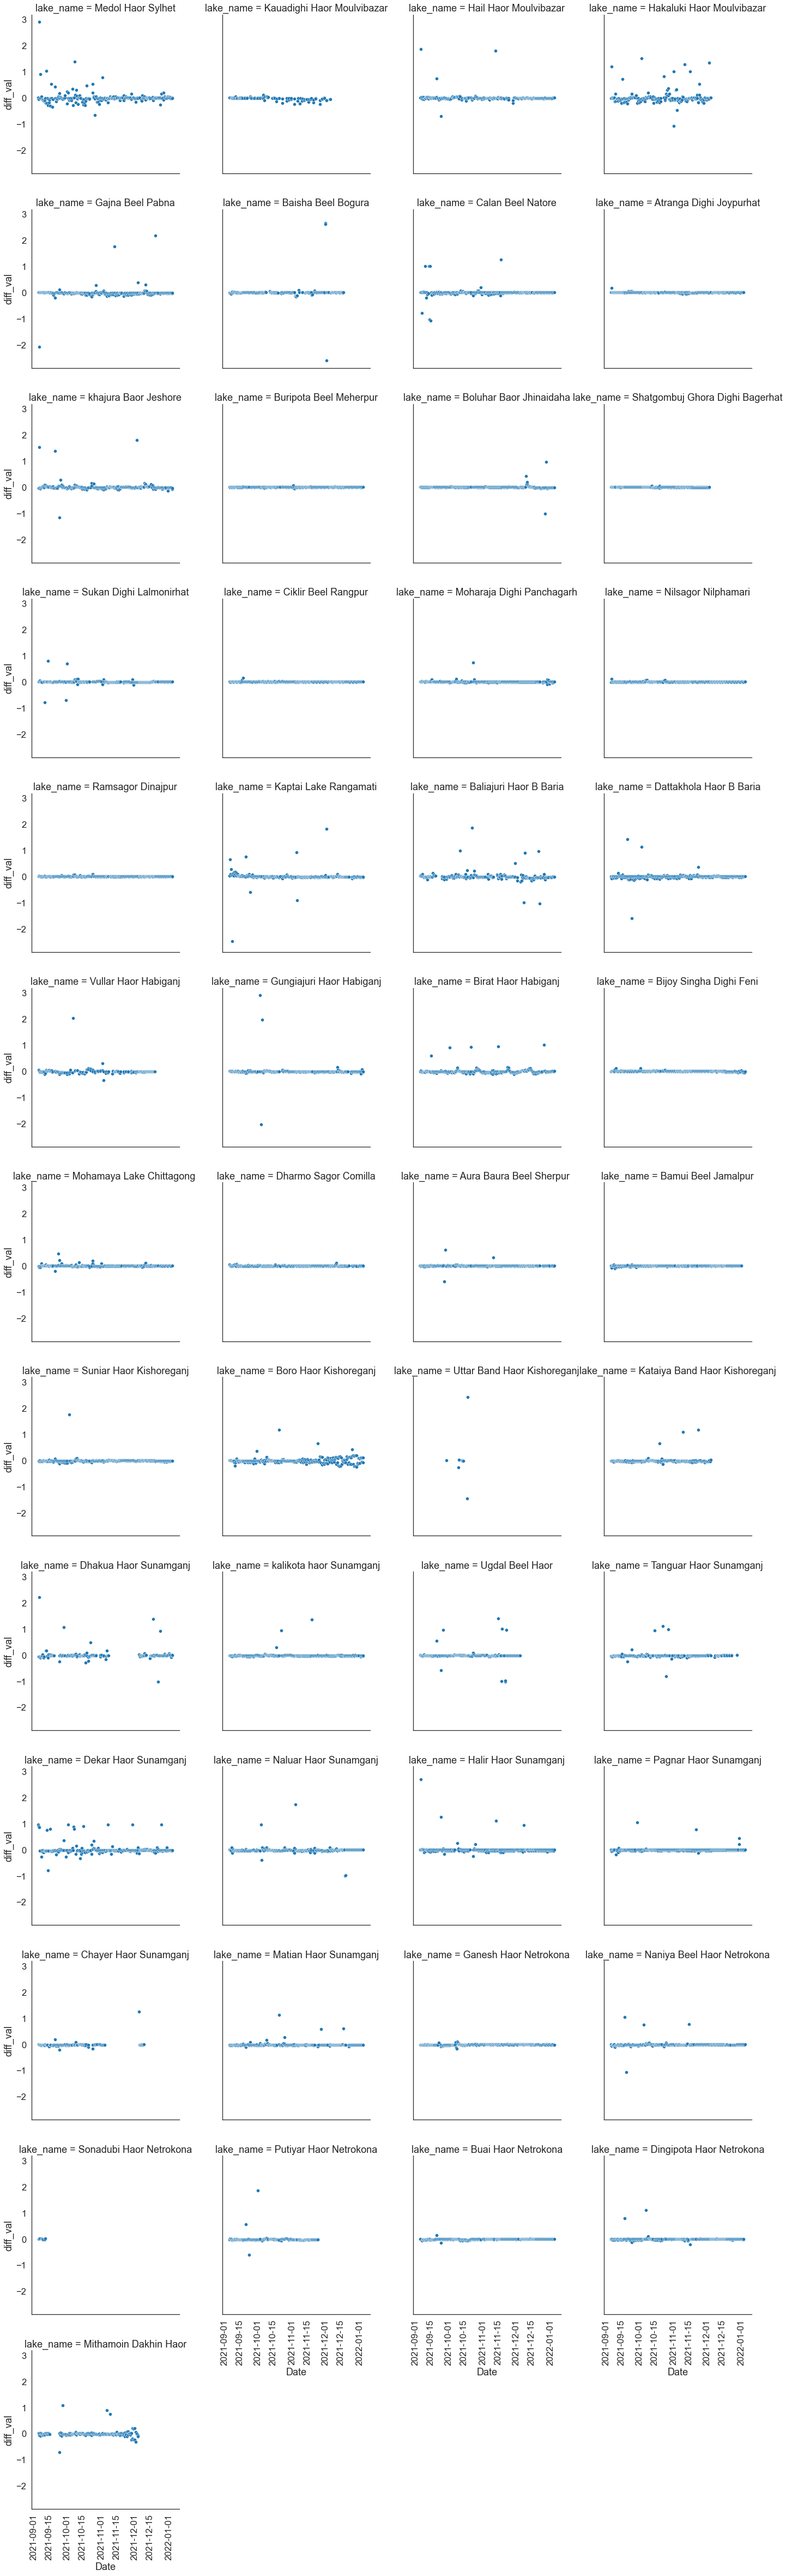

In [119]:

g_ndp=sns.relplot(data=df_dp_diff, x=date_fd,y='diff_val',col=lk_name_fd, col_wrap=4,kind='scatter')
g_ndp.set_xticklabels(rotation=90, horizontalalignment='right')

In [124]:
#Save all duplicates to a spreasheet
list_names=df_duplicates[lk_name_fd].unique()
cols_to_export=[date_fd, height_fd]
path_out='C:/Users/amgomez/Dropbox/Research/LOCSS/Docs/Bangladesh_Data_duplicate September_December.xlsx'
with pd.ExcelWriter(path_out) as writer:
    for lk_name in list_names:
        df=df_duplicates.loc[df_duplicates[lk_name_fd]==lk_name]
        df[cols_to_export].to_excel(writer, sheet_name=lk_name)
    
    

In [2]:
from ground_data import GroundObservations
import pandas as pd
import numpy as np
%load_ext autoreload
#%reload_ext autoreload
%autoreload 2

In [130]:
#Now with all locss

go=GroundObservations()
df_locss=go.read_ground_data('LOCSS')
lake_list=df_locss['gauge_id'].unique()
df_all=df_locss

date_fd='date'
height_fd='height'
st_id_fd='gauge_id'

df_duplicates_locss=pd.DataFrame()
df_final_ndp_locss=pd.DataFrame()
for lake in lake_list:
        df=df_all[df_all[st_id_fd]==lake].sort_values(by=date_fd).copy()
        df['diff_val']=df[height_fd].diff()
        df['diff_date']=df[date_fd].diff()#.apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')
        date_duplicate_mask=df[date_fd].duplicated(keep=False)
        #print('Duplicated\n',date_duplicate_mask)
        df_dp=df[date_duplicate_mask].copy()
        df_ndp=df.drop_duplicates(subset=[date_fd, st_id_fd], keep='last').copy()
        #concat to final dataframes
        # df_final=pd.concat((df_final, df), axis=0)
        df_duplicates_locss=pd.concat((df_duplicates_locss, df_dp), axis=0)
        df_final_ndp_locss =pd.concat((df_final_ndp_locss, df_ndp), axis=0)
print('df_duplicates_locss', df_duplicates_locss.shape)
print('df_final_ndp_locss', df_final_ndp_locss.shape)
print('df_locss', df_locss.shape)

df_duplicates_locss (1593, 14)
df_final_ndp_locss (40843, 14)
df_locss (41678, 12)


In [147]:
print(df_duplicates_locss.groupby(['date', st_id_fd],as_index=False).describe().shape)
df_duplicates_locss.groupby(['date', st_id_fd],as_index=False).describe()#[st_id_fd].unique().shape

(758, 40)


height                                                            \
     count    mean       std    min      25%     50%      75%    max   
0      2.0   0.900  0.000000   0.90   0.9000   0.900   0.9000   0.90   
1      2.0  10.770  0.014142  10.76  10.7650  10.770  10.7750  10.78   
2      2.0  11.080  0.000000  11.08  11.0800  11.080  11.0800  11.08   
3      2.0   1.900  0.000000   1.90   1.9000   1.900   1.9000   1.90   
4      2.0   2.200  0.000000   2.20   2.2000   2.200   2.2000   2.20   
..     ...     ...       ...    ...      ...     ...      ...    ...   
753    2.0  10.560  0.000000  10.56  10.5600  10.560  10.5600  10.56   
754    2.0   5.165  0.021213   5.15   5.1575   5.165   5.1725   5.18   
755    2.0  10.560  0.000000  10.56  10.5600  10.560  10.5600  10.56   
756    2.0   5.920  0.000000   5.92   5.9200   5.920   5.9200   5.92   
757    2.0   2.200  0.000000   2.20   2.2000   2.200   2.2000   2.20   

    min_height        ... diff_val       diff_date                          \
         count  mean  ...      75%   max     count                    mean   
0          2.0   0.0  ...  -0.0100  0.00         2         1 days 09:36:30   
1          2.0  10.0  ...   0.0200  0.02         2         0 days 12:00:00   
2          2.0  10.0  ...   0.0150  0.02         2         0 days 12:00:00   
3          2.0   0.0  ...  -0.0050  0.00         2  0 days 12:26:27.500000   
4          2.0   0.0  ...   0.0000  0.00         2         0 days 00:07:00   
..         ...   ...  ...      ...   ...       ...                     ...   
753        2.0   0.0  ...   0.0000  0.00         2         0 days 09:00:00   
754        2.0   0.0  ...   0.0125  0.03         2         0 days 03:00:00   
755        2.0   0.0  ...   0.0000  0.00         2         0 days 03:00:00   
756        2.0   0.0  ...   0.0000  0.00         2         0 days 11:18:30   
757        2.0   0.0  ...   0.0450  0.06         2         8 days 01:30:38   

                                                                          \
                            std              min                     25%   
0     1 days 23:31:45.698911520  0 days 00:00:00         0 days 16:48:15   
1     0 days 16:58:14.025894517  0 days 00:00:00         0 days 06:00:00   
2     0 days 16:58:14.025894517  0 days 00:00:00         0 days 06:00:00   
3     0 days 17:35:39.089924784  0 days 00:00:00  0 days 06:13:13.750000   
4     0 days 00:09:53.969696196  0 days 00:00:00         0 days 00:03:30   
..                          ...              ...                     ...   
753   0 days 12:43:40.519420888  0 days 00:00:00         0 days 04:30:00   
754   0 days 04:14:33.506473629  0 days 00:00:00         0 days 01:30:00   
755   0 days 04:14:33.506473629  0 days 00:00:00         0 days 01:30:00   
756   0 days 15:59:32.634124208  0 days 00:00:00         0 days 05:39:15   
757  11 days 09:39:54.907664468  0 days 00:00:00         4 days 00:45:19   

                                                                       
                        50%                     75%               max  
0           1 days 09:36:30         2 days 02:24:45   2 days 19:13:00  
1           0 days 12:00:00         0 days 18:00:00   1 days 00:00:00  
2           0 days 12:00:00         0 days 18:00:00   1 days 00:00:00  
3    0 days 12:26:27.500000  0 days 18:39:41.250000   1 days 00:52:55  
4           0 days 00:07:00         0 days 00:10:30   0 days 00:14:00  
..                      ...                     ...               ...  
753         0 days 09:00:00         0 days 13:30:00   0 days 18:00:00  
754         0 days 03:00:00         0 days 04:30:00   0 days 06:00:00  
755         0 days 03:00:00         0 days 04:30:00   0 days 06:00:00  
756         0 days 11:18:30         0 days 16:57:45   0 days 22:37:00  
757         8 days 01:30:38        12 days 02:15:57  16 days 03:01:16  

[758 rows x 40 columns]

In [131]:
df_dp=df_duplicates_locss
df_dp['is_0']=['Yes' if x==0 else 'No' for x in df_dp['diff_val']]
df_dp

,gauge_id,name,date,time,height,is_bubble_level_okay,notes,phone_no,min_height,max_height,unit,source,diff_val,diff_date,is_0
94,AFR2,Étang de Fontargente - 1,2019-08-05 12:00:00,12:00:00,2194.975,Yes,NaN,33687434931,1000.0,8000.00,METER,LOCSS,-0.02,1 days 17:20:00,No
93,AFR2,Étang de Fontargente - 1,2019-08-05 12:00:00,12:00:00,2194.965,Yes,NaN,33659560279,1000.0,8000.00,METER,LOCSS,-0.01,0 days 00:00:00,No
61,AFR2,Étang de Fontargente - 1,2020-06-27 12:00:00,12:00:00,2195.015,Yes,NaN,33661696051,1000.0,8000.00,METER,LOCSS,-0.03,1 days 00:00:00,No
62,AFR2,Étang de Fontargente - 1,2020-06-27 12:00:00,12:00:00,2195.015,Yes,NaN,33673070628,1000.0,8000.00,METER,LOCSS,0.00,0 days 00:00:00,Yes
0,AFR2,Étang de Fontargente - 1,2021-08-05 12:00:00,12:00:00,2195.045,Yes,NaN,NaN,1000.0,8000.00,METER,LOCSS,-0.03,3 days 00:00:00,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41658,YSL2,Grays Lake,2020-08-22 11:45:00,11:45:00,1.800,No,NaN,NaN,0.0,3.33,FEET,LOCSS,0.00,0 days 00:00:00,Yes
41660,YSL2,Grays Lake,2020-09-12 14:15:00,14:15:00,2.000,No,NaN,NaN,0.0,3.33,FEET,LOCSS,0.22,20 days 21:12:00,No
41661,YSL2,Grays Lake,2020-09-12 14:15:00,14:15:00,2.000,No,NaN,NaN,0.0,3.33,FEET,LOCSS,0.00,0 days 00:00:00,Yes
41669,YSL2,Grays Lake,2020-10-09 17:25:00,17:25:00,1.640,No,NaN,NaN,0.0,3.33,FEET,LOCSS,-0.20,0 days 00:56:08,No


In [152]:
df_duplicates_locss.loc[df_duplicates_locss['unit']=='CM'].gauge_id.unique()

array(['HFR2', 'SFR2'], dtype=object)

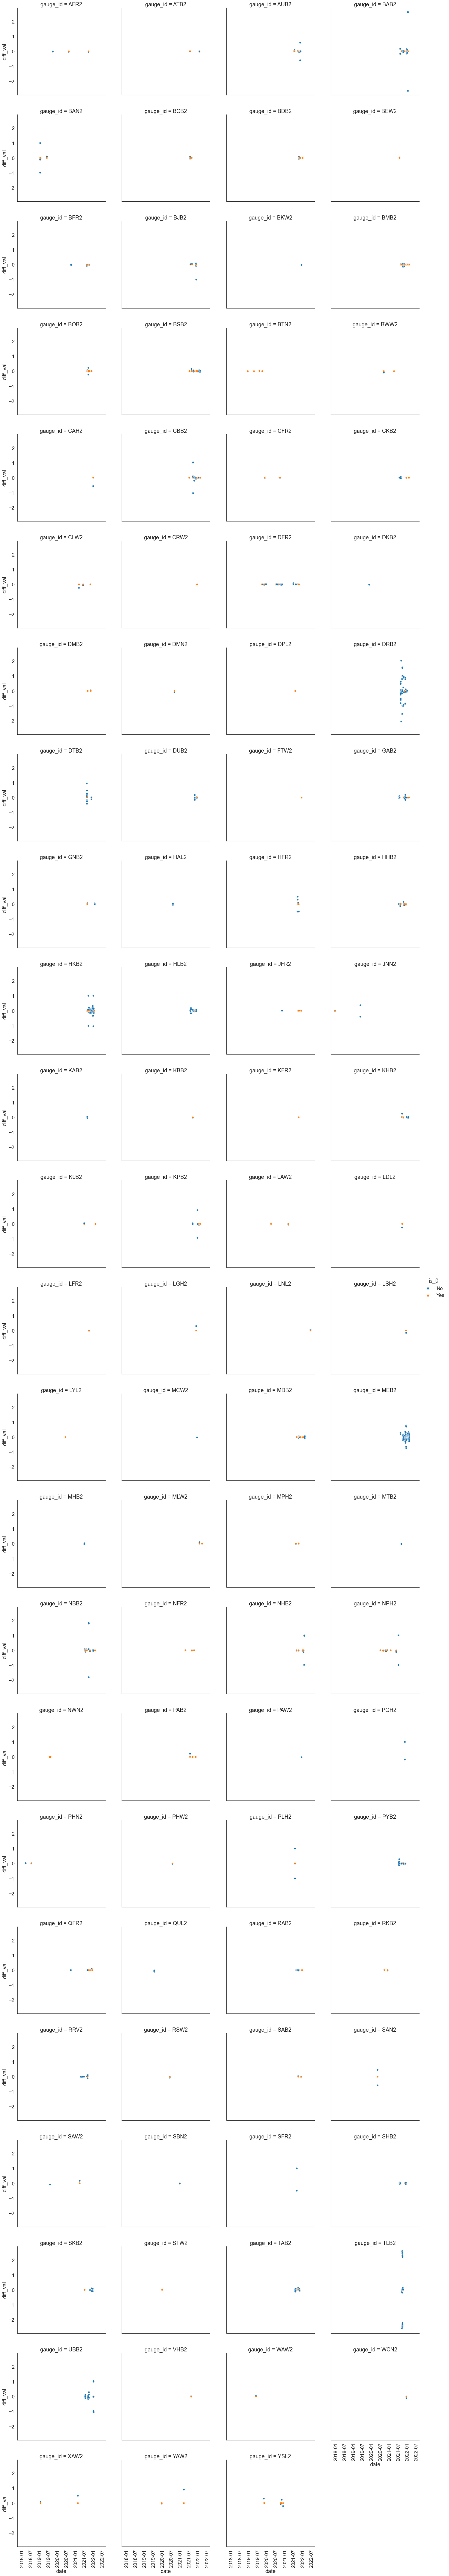

In [132]:
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)

g_ndp=sns.relplot(data=df_duplicates_locss, x=date_fd,y='diff_val',
                  hue='is_0',col='gauge_id', col_wrap=4,kind='scatter')
g_ndp.set_xticklabels(rotation=90, horizontalalignment='right')

In [133]:
#Save the duplicates non 0 in a excel file 
df_duplicates_locss_neq=df_duplicates_locss.loc[df_duplicates_locss['is_0']=='No'].copy()
df_stats_duplicates_neq=df_duplicates_locss_neq[[st_id_fd, date_fd, 'height']].groupby([st_id_fd, date_fd]).describe().reset_index()
stats_fd=['count','mean','std','min','q_25', 'q_50', 'q_75','max']
var_fd='height'
additional_fd=[st_id_fd, date_fd]
df_stats_duplicates_neq=change_statfd_names(df_stats_duplicates_neq,stats_fd, [var_fd], additional_fd)
df_stats_duplicates_neq=df_stats_duplicates_neq.loc[~df_stats_duplicates_neq['height_std'].isnull()&
                                                    (temp['height_std']>=0.1)]

len(df_stats_duplicates_neq.gauge_id.unique())
print(df_stats_duplicates_neq.shape)

(96, 10)


(0.0, 40.0)

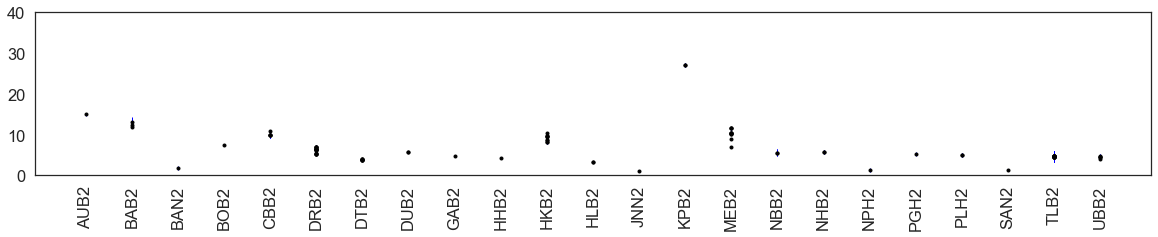

In [134]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
# stations=df_stats_duplicates_neq['gauge_id'].unique()
# for st in stations:
#     df=df_stats_duplicates_neq.loc[df_stats_duplicates_neq['gauge_id']==st]
df_stats_duplicates_neq['region']=[x[2:] for x in df_stats_duplicates_neq[st_id_fd]]
df_stats_duplicates_neq_1=df_stats_duplicates_neq.loc[df_stats_duplicates_neq['region']!='R2']
x=      df_stats_duplicates_neq_1[st_id_fd].values
mins =  df_stats_duplicates_neq_1['height_min'].values
maxes = df_stats_duplicates_neq_1['height_max'].values
means = df_stats_duplicates_neq_1['height_mean'].values
std =   df_stats_duplicates_neq_1['height_std'].values

# create stacked errorbars:
#plt.errorbar(x=x, y=means, yerr=std, fmt='ok', lw=1)
plt.errorbar(x, means, [means - mins, maxes - means],
         fmt='.k', ecolor='blue', lw=1)
plt.xticks(rotation=90)
plt.ylim(0, 40)

In [103]:
df_duplicates_locss_neq

,gauge_id,name,date,time,height,is_bubble_level_okay,notes,phone_no,min_height,max_height,unit,source,diff_val,diff_date,is_0
94,AFR2,Étang de Fontargente - 1,2019-08-05 12:00:00,12:00:00,2194.975,Yes,NaN,33687434931,1000.0,8000.00,METER,LOCSS,-0.02,1 days 17:20:00,No
93,AFR2,Étang de Fontargente - 1,2019-08-05 12:00:00,12:00:00,2194.965,Yes,NaN,33659560279,1000.0,8000.00,METER,LOCSS,-0.01,0 days 00:00:00,No
61,AFR2,Étang de Fontargente - 1,2020-06-27 12:00:00,12:00:00,2195.015,Yes,NaN,33661696051,1000.0,8000.00,METER,LOCSS,-0.03,1 days 00:00:00,No
0,AFR2,Étang de Fontargente - 1,2021-08-05 12:00:00,12:00:00,2195.045,Yes,NaN,NaN,1000.0,8000.00,METER,LOCSS,-0.03,3 days 00:00:00,No
278,ATB2,Atranga Dighi,2021-06-01 09:00:00,09:00:00,15.280,NaN,NaN,NaN,0.0,20.00,METER,LOCSS,0.02,0 days 18:00:00,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41442,YAW2,Lake Martha,2021-01-28 08:25:00,08:25:00,3.000,Yes,NaN,NaN,0.0,3.33,FEET,LOCSS,0.90,5 days 17:08:00,No
41582,YSL2,Grays Lake,2019-09-11 20:20:00,20:20:00,2.340,No,Tornado Warning at 7:00 pm ;Bad storms in area.,NaN,0.0,3.33,FEET,LOCSS,0.30,6 days 04:35:00,No
41657,YSL2,Grays Lake,2020-08-22 11:45:00,11:45:00,1.800,No,NaN,NaN,0.0,3.33,FEET,LOCSS,-0.06,13 days 16:26:24,No
41660,YSL2,Grays Lake,2020-09-12 14:15:00,14:15:00,2.000,No,NaN,NaN,0.0,3.33,FEET,LOCSS,0.22,20 days 21:12:00,No


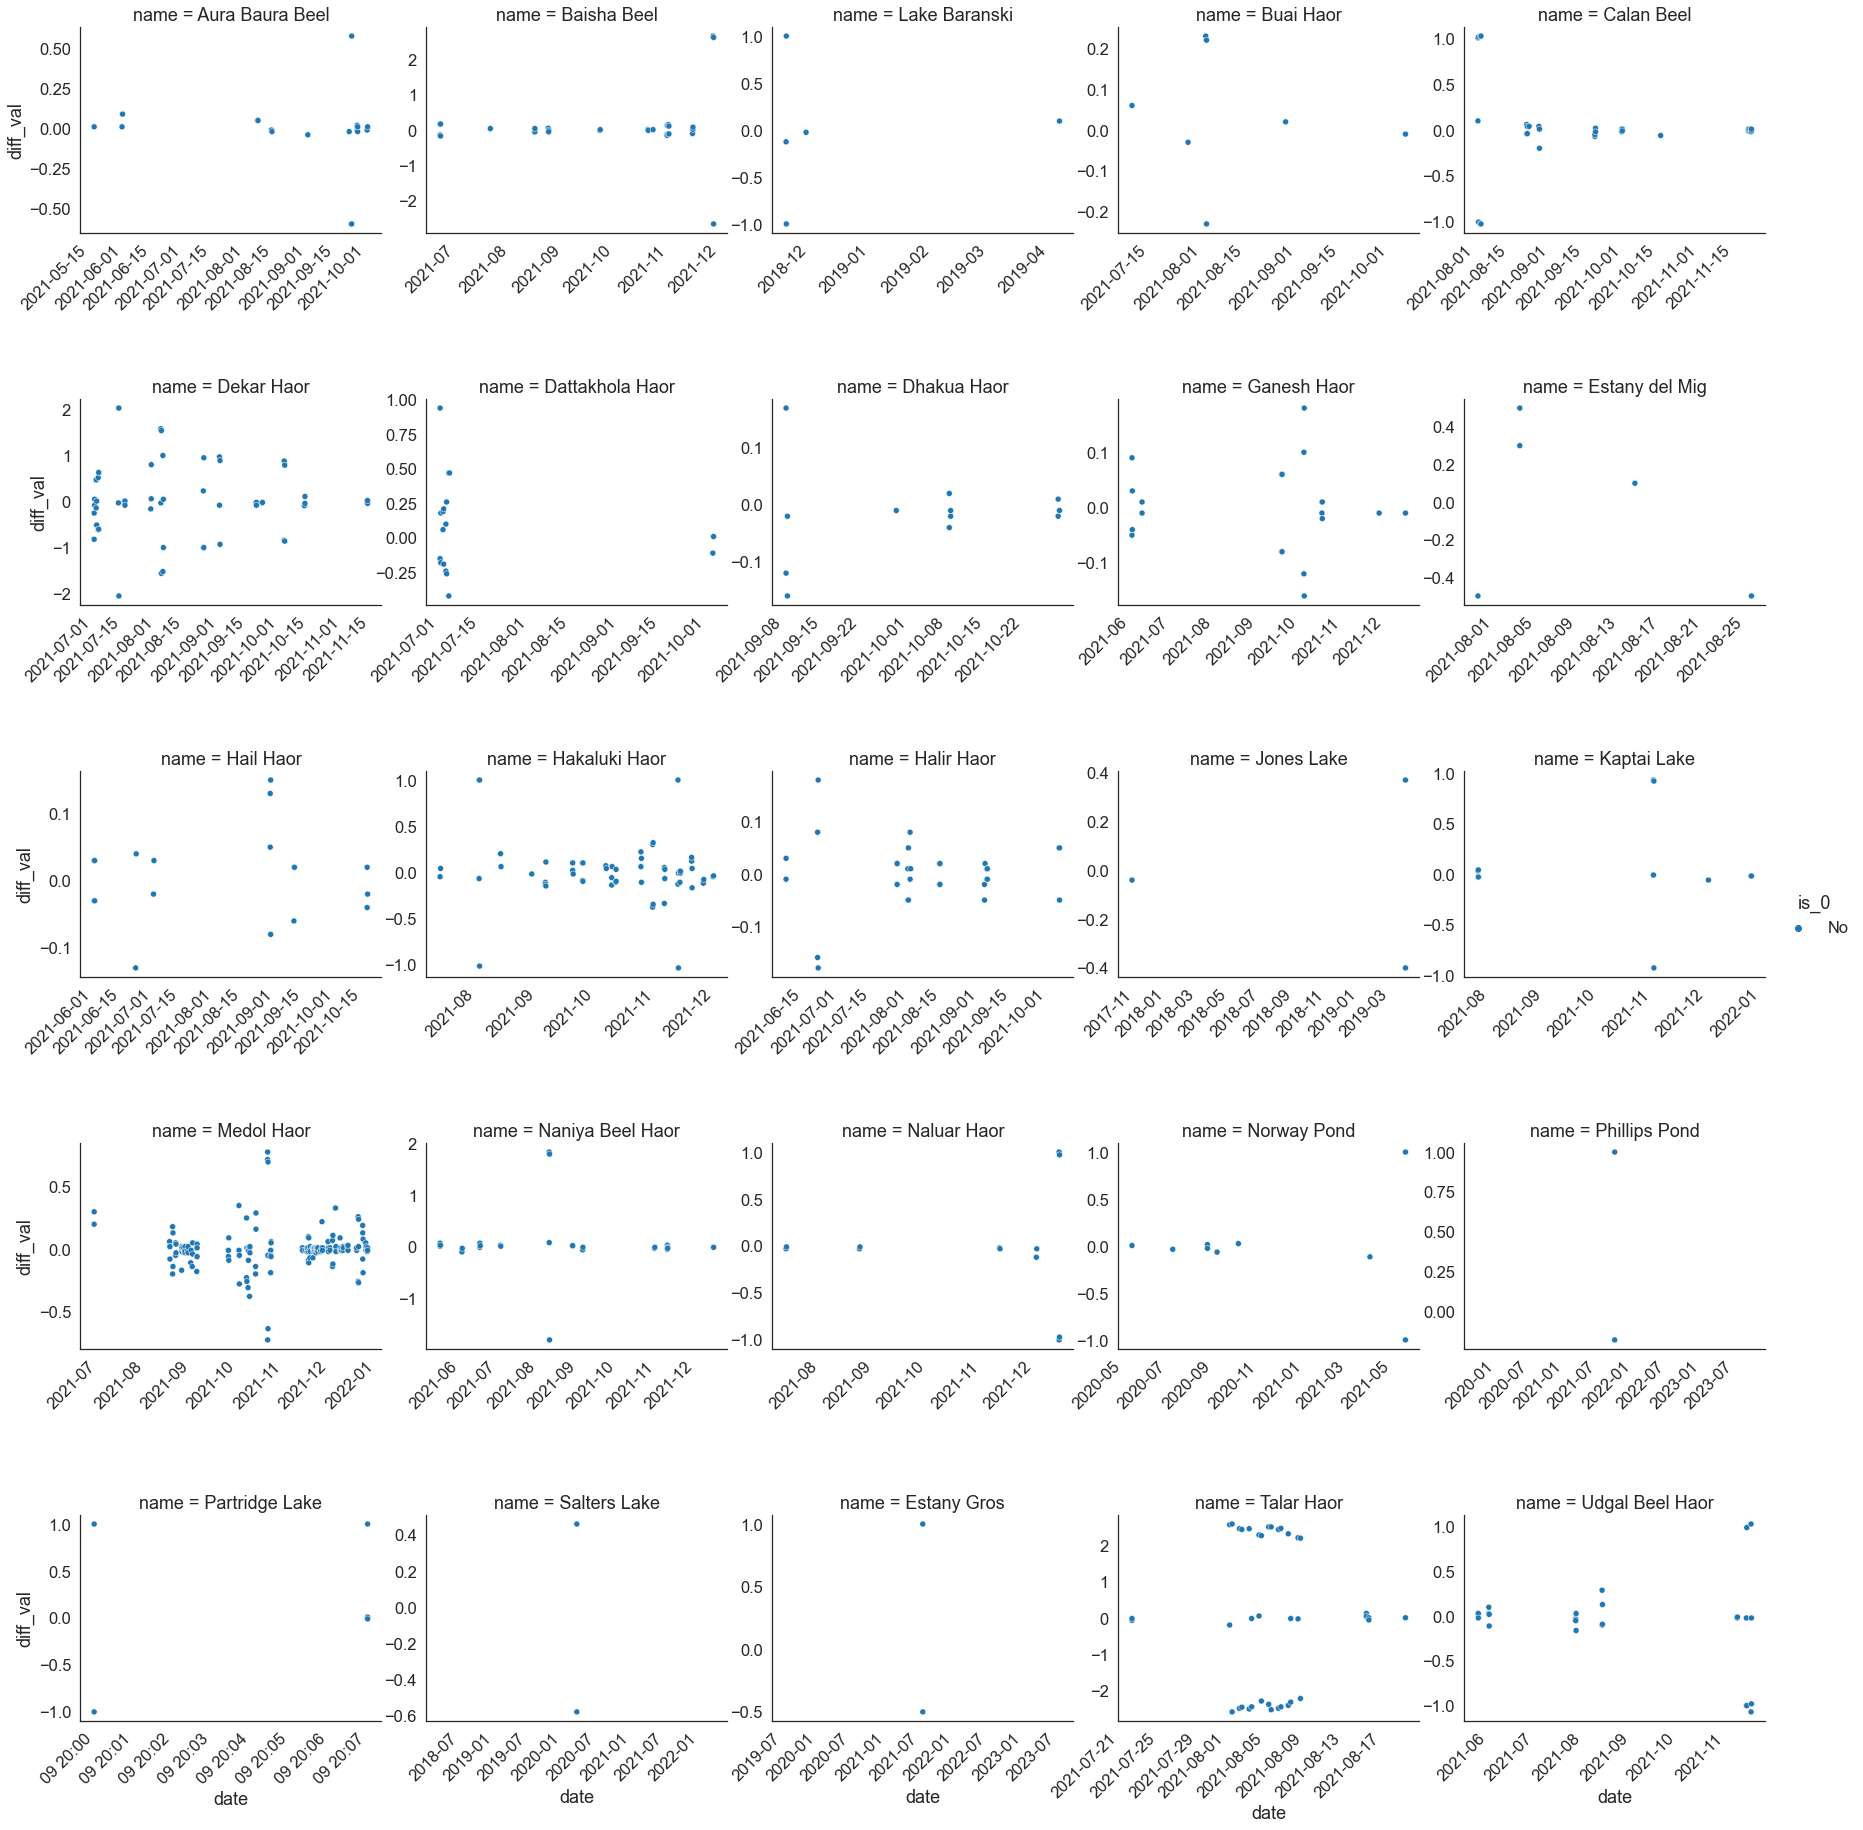

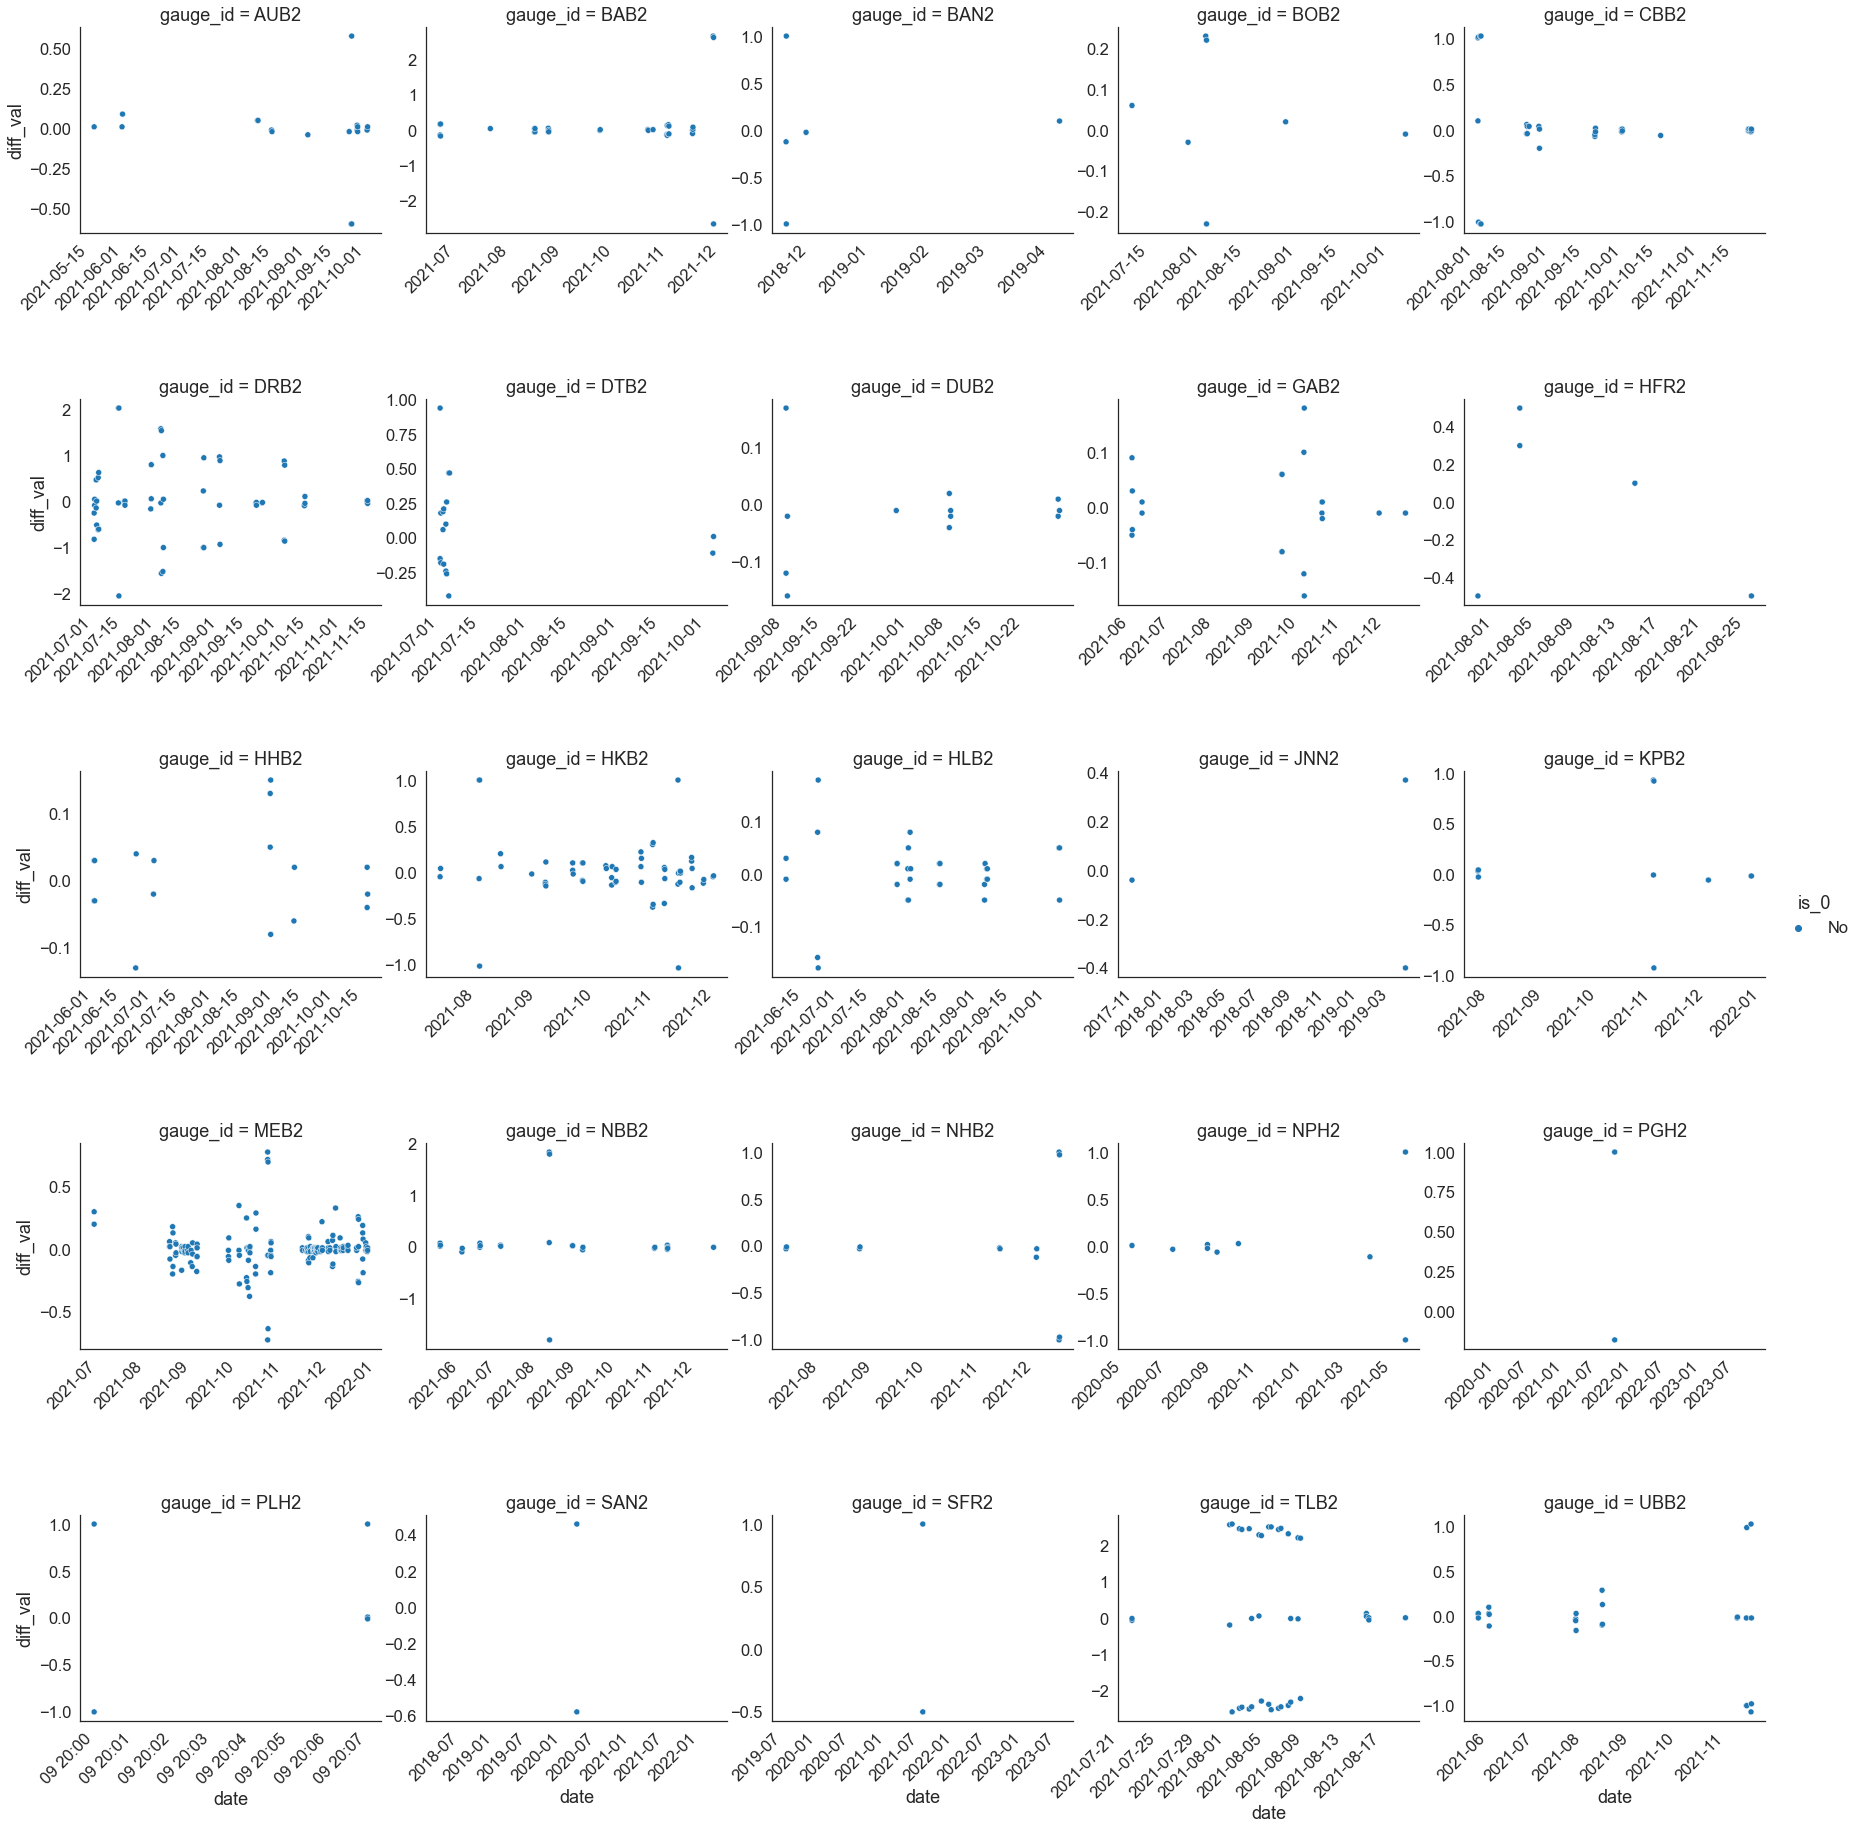

In [139]:
import seaborn as sns
from datetime import date

sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)

#Refactor https://stackoverflow.com/questions/61085809/how-to-prevent-seaborn-facetgrid-from-overlapping-when-wrapped
df=df_duplicates_locss_neq.loc[df_duplicates_locss_neq[st_id_fd].isin(df_stats_duplicates_neq[st_id_fd].unique())]
x_field=date_fd
y_field='diff_val'
hue='is_0'
col='name'
col_wrap=5
facet_kws={'sharey': False, 'sharex': False}
#Split the figure in two


g_sn=sns.relplot(data=df, 
                 x=x_field, y=y_field, hue=hue, 
                 col=col,col_wrap=col_wrap, facet_kws=facet_kws)#, aspect=0.7, height=5.5)
g_sn.fig.subplots_adjust(hspace=0.8, wspace=.15)
g_sn.set_xticklabels(rotation=45, horizontalalignment='right')
g_sn.savefig('../data/dup_bg_by_date_neq_gt01'+date.today().strftime("%Y%m%d")+'.png')

col=st_id_fd
g_sn=sns.relplot(data=df, 
                 x=x_field, y=y_field, hue=hue, 
                 col=col,col_wrap=col_wrap, facet_kws=facet_kws)#, aspect=0.7, height=5.5)
g_sn.fig.subplots_adjust(hspace=0.8, wspace=.15)
g_sn.set_xticklabels(rotation=45, horizontalalignment='right')
g_sn.savefig('../data/dup_bg_by_date_neq_gt01_id'+date.today().strftime("%Y%m%d")+'.png')


In [138]:
#Save all duplicates to a spreasheet
df_dneq=df_duplicates_locss_neq.loc[df_duplicates_locss_neq[st_id_fd].isin(df_stats_duplicates_neq[st_id_fd].unique())]
list_names=df_dneq['name'].unique()
cols_to_export=[st_id_fd, date_fd, height_fd, 'phone_no']
path_out='C:/Users/amgomez/Dropbox/Research/LOCSS/Docs/Duplicates_noneq_gt01_'+date.today().strftime("%Y%m%d")+'.xlsx'
with pd.ExcelWriter(path_out) as writer:
    for lk_name in list_names:
        df=df_dneq.loc[df_dneq['name']==lk_name]
        df[cols_to_export].to_excel(writer, sheet_name=lk_name)

In [120]:
df_duplicates_locss_neq

,gauge_id,name,date,time,height,is_bubble_level_okay,notes,phone_no,min_height,max_height,unit,source,diff_val,diff_date,is_0
94,AFR2,Étang de Fontargente - 1,2019-08-05 12:00:00,12:00:00,2194.975,Yes,NaN,33687434931,1000.0,8000.00,METER,LOCSS,-0.02,1 days 17:20:00,No
93,AFR2,Étang de Fontargente - 1,2019-08-05 12:00:00,12:00:00,2194.965,Yes,NaN,33659560279,1000.0,8000.00,METER,LOCSS,-0.01,0 days 00:00:00,No
61,AFR2,Étang de Fontargente - 1,2020-06-27 12:00:00,12:00:00,2195.015,Yes,NaN,33661696051,1000.0,8000.00,METER,LOCSS,-0.03,1 days 00:00:00,No
0,AFR2,Étang de Fontargente - 1,2021-08-05 12:00:00,12:00:00,2195.045,Yes,NaN,NaN,1000.0,8000.00,METER,LOCSS,-0.03,3 days 00:00:00,No
278,ATB2,Atranga Dighi,2021-06-01 09:00:00,09:00:00,15.280,NaN,NaN,NaN,0.0,20.00,METER,LOCSS,0.02,0 days 18:00:00,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41442,YAW2,Lake Martha,2021-01-28 08:25:00,08:25:00,3.000,Yes,NaN,NaN,0.0,3.33,FEET,LOCSS,0.90,5 days 17:08:00,No
41582,YSL2,Grays Lake,2019-09-11 20:20:00,20:20:00,2.340,No,Tornado Warning at 7:00 pm ;Bad storms in area.,NaN,0.0,3.33,FEET,LOCSS,0.30,6 days 04:35:00,No
41657,YSL2,Grays Lake,2020-08-22 11:45:00,11:45:00,1.800,No,NaN,NaN,0.0,3.33,FEET,LOCSS,-0.06,13 days 16:26:24,No
41660,YSL2,Grays Lake,2020-09-12 14:15:00,14:15:00,2.000,No,NaN,NaN,0.0,3.33,FEET,LOCSS,0.22,20 days 21:12:00,No


In [34]:
#Get statistics for each value 
#Code from https://stackoverflow.com/questions/47637774/pandas-groupby-quantile-values/58535752
def rename(newname):
    def decorator(f):
        f.__name__ = newname
        return f
    return decorator
#Define quatiles at a percentage define by y
def q_at(y):
    @rename(f'q{y:0.3f}')
    def q(x):
        return x.quantile(y)
    return q
#To change names of level col name specially after stats are calculated with describe 
def change_statfd_names(df,stats_fd, var_fd, additional_fd):
    name_vs=[]
    for vfd in var_fd:
        name_vs=name_vs+[vfd+'_'+sfd for sfd in stats_fd]
    new_colnames=additional_fd+name_vs
    df.columns=new_colnames
    return df

In [158]:
field='height'
f = {field: ['median', 'std', 'max','min', q_at(0.95),q_at(0.999) ,q_at(0.01)]}
stats_fd=['median', 'std', 'max','min','p_95','p_99','p_001']
df_ci_bstats=df_locss[['gauge_id','height']].groupby('gauge_id').agg(f).reset_index()
df_ci_bstats

df_ci_bstats=change_statfd_names(df=df_ci_bstats,stats_fd=stats_fd, var_fd=[field], additional_fd=['gauge_id'])


In [168]:
df=pd.melt(df_ci_bstats, id_vars='gauge_id').head(2)
# df_ci_bstats.head()
df.loc[df['variable'].isin(['height_median','height_p_95','height_p_99'])]

,gauge_id,variable,value
0,AFR2,height_median,2194.995
1,AMH2,height_median,5.58


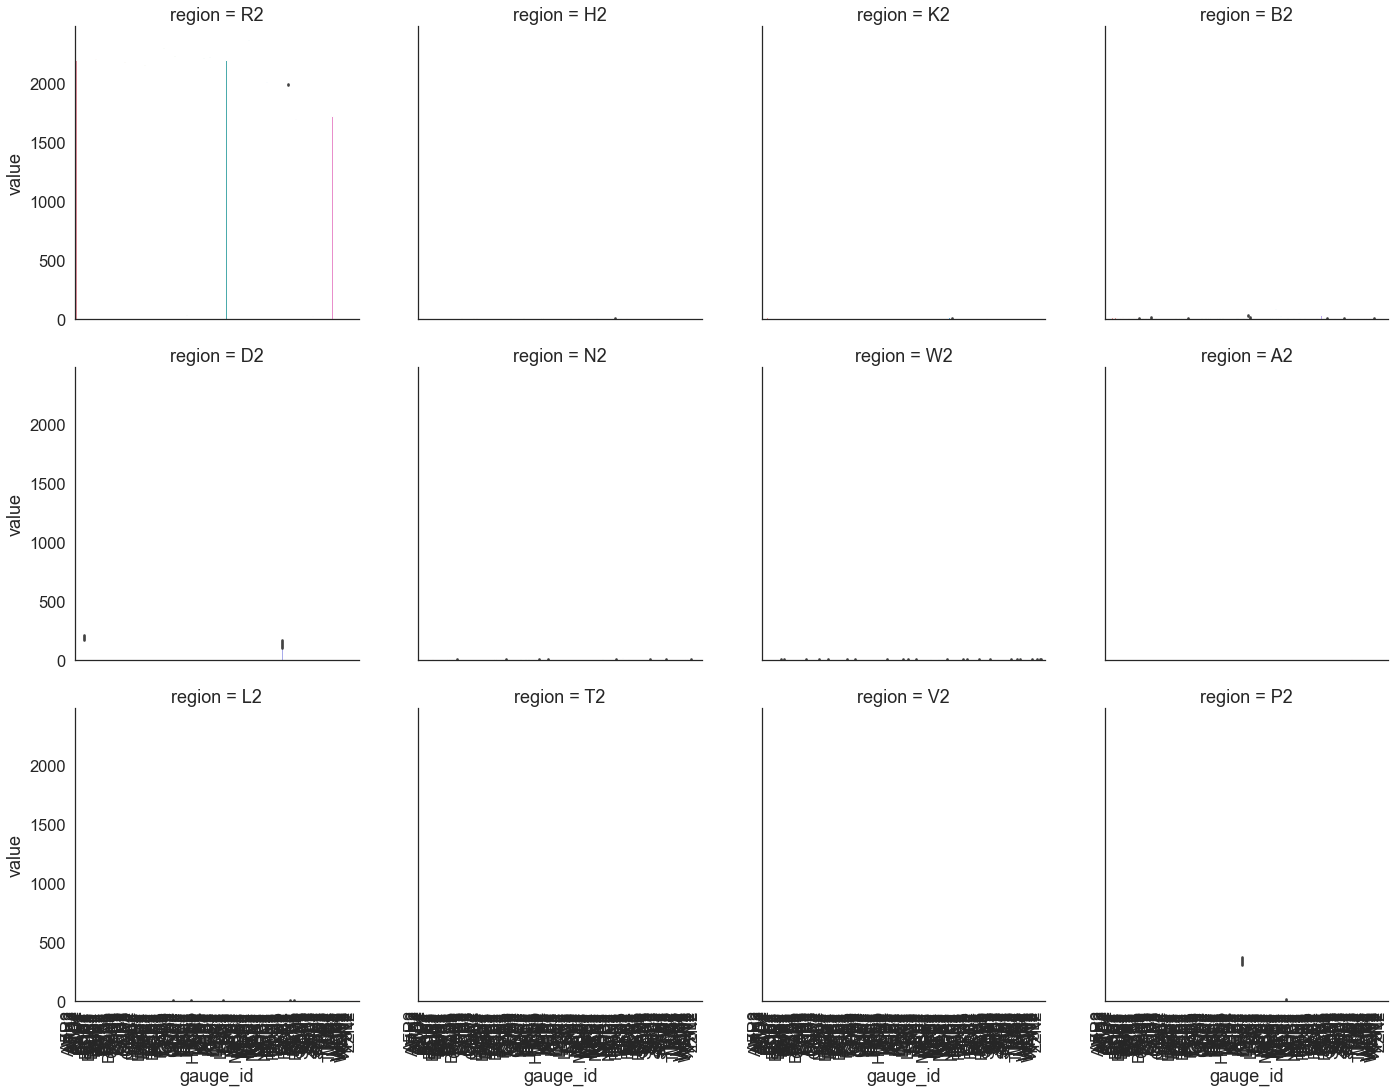

In [176]:
sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)

df=df_ci_bstats

df=pd.melt(df_ci_bstats, id_vars='gauge_id')
df=df.loc[df['variable'].isin(['height_median','height_p_95','height_p_99'])]
df['region']=[x[2:] for x in df['gauge_id']]
x_field='gauge_id'
y_field='value'
hue='variable'
col='region'
col_wrap=4
facet_kws={'sharey': False, 'sharex': False}
#Split the figure in two
g=sns.catplot(data=df, x=x_field, y=y_field, col=col, col_wrap=4, kind='bar',facet_kws=facet_kws)
g.set_xticklabels(rotation=90, horizontalalignment='right')

In [175]:
#Test function for converting units 
from ts_preprocesing import *
conv_dic={'FEET':{'METER':0.3048,'CM':30.48, 'FEET':1},
              'CM': {'METER':0.01,'FEET':0.03281,'CM':1},
              'METER':{'FEET':3.28084,'CM':100,'METER':1}}
origin='FEET'
to='METER'
df=pd.DataFrame({'data':[1,2,3,4,1,2,3,4],
                'st':['a','a','a','a','b','b','c','c'],
                'unit':['CM','CM','CM','CM','FEET','FEET','METER','METER']})
height_fd='data'
st='st'
convert_units(df,height_fd, origin=origin, to=to, check_col=True, unit_fd='unit',
                  gauge_fd=st)
# conversion_factor=conv_dic[origin][to]

# any(origin in conv_dic.keys())
 


,height_rw,st,unit,height
0,1,a,CM,0.0100
1,2,a,CM,0.0200
2,3,a,CM,0.0300
3,4,a,CM,0.0400
4,1,b,FEET,0.3048
5,2,b,FEET,0.6096
6,3,c,METER,3.0000
7,4,c,METER,4.0000
